In [1]:
import os
from datetime import datetime
# Make logging folder named according to current time
start_time_str = datetime.today().strftime('%d_%m_%Y__%H_%M_%S')
log_dir = './logs/'f"log_{start_time_str}"
os.makedirs(log_dir)

# Initialize logger that adds to text file in current logging folder
from logging_utils import *


# Initialize logger that adds to text file in current logging folder
from logging_utils import *
init_logger(save_dir=log_dir)
logger = get_logger()

In [2]:
import pathlib
import subprocess
# Get the absolute path to your repository, 
# no matter where you are running this code from

repo_path = os.getcwd() 


git_branch = subprocess.check_output(
    ["git", "-C", repo_path, "rev-parse", "--abbrev-ref", "HEAD"]).strip().decode('UTF-8')

git_commit_short_hash = subprocess.check_output(
    ["git", "-C", repo_path, "describe", "--always"]).strip().decode('UTF-8')


In [3]:
from src_dir import *
import numpy as np

dim=20


x0=np.squeeze(np.zeros((dim,dim)))
x0Type='Zero Solution 2D'

# FD_StencilMat=np.zeros((dim,dim))
# b = np.ones(dim-1)
# c = -2*np.ones(dim)
# np.fill_diagonal(FD_StencilMat[1:], b)
# np.fill_diagonal(FD_StencilMat[:,1:], b)
# np.fill_diagonal(FD_StencilMat, c)
# A=FD_StencilMat
# A=np.asmatrix(A)

A=mk_laplace_2d(dim,dim)
AType='2D Laplacian'

retrain_freq=1
e1 = 1e-5
e2 = 1e-6
nmax_iter =int(dim/5)
restart   = 64

# sigma=0.02
sigma=0.2


DomainL=-1.0
DomainR=1.0

x1=np.linspace(DomainL,DomainR,dim)
x2=np.linspace(DomainL,DomainR,dim)
X, Y = np.meshgrid(x1, x2, sparse=False, indexing='ij')

n_steps =4000
InputDim=dim
HiddenDim=dim
OutputDim=dim

In [4]:
# check 2d grid and RHS

import matplotlib.pyplot as pp
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = pp.figure()
ax = fig.add_subplot(111, projection='3d')
ProbIdx=50

# Z=np.sin(1)*X+np.cos(1)*Y

xloc=np.cos(6*ProbIdx)*np.cos(ProbIdx)
yloc=np.cos(6*ProbIdx)*np.sin(ProbIdx)
Z=Gauss_pdf_2D(X,Y,xloc,yloc,sigma)

# Z=np.maximum(2*X*np.sin(ProbIdx),2*Y*np.cos(ProbIdx))

ax.plot_surface(X,Y,Z,cmap=cm.coolwarm)

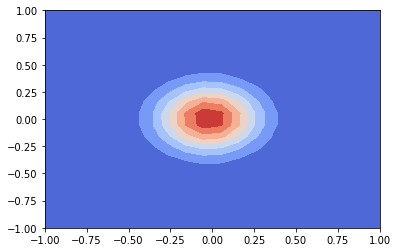

In [5]:
pp.contourf(X,Y,Z,cmap=cm.coolwarm)

In [6]:
# Initial log message
logger.info("Test 2D problem using 2 2DConv (Kernels are 9x9,9x9) + 1 FC . Dim 20. Wide source (sig-0.2). e1=10^{-5}. 'Standard network parameters'. 4000 problems ")
#  The source is a narrow gaussian that depends on the integer 'time' in a nonlinear way. The gaussian is on the interval [-5,5], and constrained to move on [-3,3]. ")



# Set up parameter class
class MyParamsClass():
    def __init__(self, AType,dim,nmax_iter,restart,retrain_freq,e1,e2,x0Type,n_steps,InputDim,HiddenDim,OutputDim,sigma,DomainL,DomainR,git_branch,git_commit_short_hash):
        self.AType = AType
        self.dim = dim
        self.nmax_iter = nmax_iter
        self.restart = restart
        self.n_steps =n_steps
        self.retrain_freq=retrain_freq
        self.e1=e1
        self.e2=e2
        self.x0Type=x0Type
        self.InputDim=InputDim
        self.HiddenDim=HiddenDim
        self.OutputDim=OutputDim
        self.sigma=sigma
        self.DomainL=DomainL
        self.DomainR=DomainR
        self.git_branch=git_branch
        self.git_commit_short_hash=git_commit_short_hash





import os
import json

params = MyParamsClass(AType,dim,nmax_iter,restart,retrain_freq,e1,e2,x0Type,n_steps,InputDim,HiddenDim,OutputDim,sigma,DomainL,DomainR,git_branch,git_commit_short_hash)
sorted_params_dict = {k: params.__dict__[k] for k 
                      in sorted(params.__dict__.keys())}

params_filepath = log_dir+'/params.json'
json.dump(sorted_params_dict, open(params_filepath, 'w'), indent=4)

2020-07-01 21:10:50 [INFO] <ipython-input-6-54cfe185e264> 2 - Test 2D problem using 2 2DConv (Kernels are 9x9,9x9) + 1 FC . Dim 20. Wide source (sig-0.2). e1=10^{-5}. 'Standard network parameters'. 4000 problems 


In [7]:
from src_dir import *

# @nn_preconditioner(retrain_freq=retrain_freq, debug=True,InputDim=InputDim,HiddenDim=HiddenDim,HiddenDim2=HiddenDim2,OutputDim=OutputDim)
# def MLGMRES(A, b, x0, e, nmax_iter,IterErr0_sum,IterErr0,ProbCount,Add,restart,debug):
#     return GMRES(A, b, x0, e, nmax_iter,restart, debug)



@timer
@cnn_preconditionerOnline_timed_2D(retrain_freq=retrain_freq, debug=True,InputDim=InputDim,HiddenDim=HiddenDim,OutputDim=OutputDim)
def MLGMRES(A, b ,x0, e, nmax_iter,ML_GMRES_Time_list,ProbCount,restart,debug,refine,blist,reslist,Err_list,reslist_flat,ML_GMRES_Time_list2):
    return GMRES(A, b, x0, e, nmax_iter,restart, debug)



@timer
def GMRES_timed(A, b, x0, e, nmax_iter,restart,debug):
    return GMRES(A, b, x0, e, nmax_iter,restart, debug)

In [8]:
from src_dir import *



ML_GMRES_Time_list=[]
ML_GMRES_Time_list2=[]

Err_list=[]
NonML_Err_List=[]

run_time_ML_list=[]
run_timeP1_ML_list=[]
run_timeP2_ML_list=[]

run_time_list=[]
GmresRunTimeOriginal=[]
GmresRunTimeOriginal2=[]

trainTime_list=[]


debug=True
refine1=False
refine2=True

blist=[]
reslist=[]
reslist_flat=[]


for ProbIdx in range(n_steps):


    xloc=np.cos(6*ProbIdx)*np.cos(ProbIdx)
    yloc=np.cos(6*ProbIdx)*np.sin(ProbIdx)
    b=Gauss_pdf_2D(X,Y,xloc,yloc,sigma)


#     b=np.maximum(2*X*np.sin(ProbIdx),2*Y*np.cos(ProbIdx))

    b_flat=np.reshape(b,(1,-1),order='F').squeeze(0)
    b_norm=np.linalg.norm(b_flat)


    OutList1,run_time1_ML=MLGMRES(A, b/b_norm, x0, e1, nmax_iter,ML_GMRES_Time_list,ProbIdx,restart,debug,refine1,blist,reslist,Err_list,reslist_flat,ML_GMRES_Time_list2)  # normalize b for optimal NN performance.
    Out=OutList1[0]
    ML_GMRES_Time_list=OutList1[1]
    blist=OutList1[3]
    reslist=OutList1[4]
    Err_list=OutList1[5]
    reslist_flat=OutList1[6]

    OutList2,run_time2_ML=MLGMRES(A, b/b_norm,Out[-1], e2, nmax_iter,ML_GMRES_Time_list,ProbIdx,restart,debug,refine2,blist,reslist,Err_list,reslist_flat,ML_GMRES_Time_list2)
    Out2=OutList2[0]
    ML_GMRES_Time_list=OutList2[1]
    trainTime_list.append(OutList2[2])
    blist=OutList2[3]
    reslist=OutList2[4]
    Err_list=OutList2[5]
    reslist_flat=OutList2[6]
    ML_GMRES_Time_list2=OutList2[7]

    run_timeP1_ML_list.append(run_time1_ML)
    run_timeP2_ML_list.append(run_time2_ML)
    run_time_ML_list.append(run_time1_ML+run_time2_ML)
    



    NonML_Out1,run_time1=GMRES_timed(A, b/b_norm, x0, e1, nmax_iter,restart, debug)  # normalize b for optimal NN performance.
    NonML_Err=resid(A, NonML_Out1, b/b_norm)
    NonML_Err_List.append(NonML_Err[5])
   
    NonML_Out2,run_time2=GMRES_timed(A, b/b_norm, NonML_Out1[-1], e2, nmax_iter,restart, debug)  # normalize b for optimal NN performance.
    
    GmresRunTimeOriginal.append(run_time1)
    GmresRunTimeOriginal2.append(run_time2)
    run_time_list.append(run_time1+run_time2)
    
    MLGMRES_GMRES_ONLY=sum(ML_GMRES_Time_list2)+sum(ML_GMRES_Time_list)

    print(ProbIdx)


run_time=sum(run_time_list)
run_time_ML=sum(run_time_ML_list)
trainTime_total=sum(trainTime_list)


logger.info("Runtime of Non-decorated version is:")
logger.info(run_time)

logger.info("Runtime of MLGMRES decorator is:")
logger.info(run_time_ML)

logger.info("Runtime of MLGMRES (only GMRES time) is:")
logger.info(MLGMRES_GMRES_ONLY)


logger.info("Runtime of training (backprop) is:")
logger.info(trainTime_total)



0
1
Final loss: 8.75889145390829e-06
parameters 160562
Initial Training
2
size 8
0.47264198131409296 0.3141709155420794
poor prediction,using initial x0
0.6434106590004376 0.7667343845005234 0.3475997418560292 0.30004747255821695
0.6434106590004376 0.7667343845005234 0.3475997418560292 0.30004747255821695
3
size 8
0.5241772407883853 0.3475997418560292
poor prediction,using initial x0
0.8265778059994773 0.756117756000549 0.38814273954532025 0.3308853286990543
0.8265778059994773 0.756117756000549 0.38814273954532025 0.3308853286990543
4
size 8
0.5462243984615205 0.38814273954532025
poor prediction,using initial x0
1.0142936470001587 0.7796044393335251 0.4188455161556195 0.3499711323144763
1.0142936470001587 0.7796044393335251 0.4188455161556195 0.3499711323144763
5
size 8
0.5427507862304403 0.4188455161556195
poor prediction,using initial x0
0.8457597269998587 0.8280940373333578 0.41935701556881927 0.3848626658523229
0.8457597269998587 0.8280940373333578 0.41935701556881927 0.38486266585

0.5659420969996063 0.6006610234400432 0.7646376163267469 0.5482462432148822
40
size 8
0.4772119314821956 1.0175686973388376
0.5901336799997807 0.5995596668800135 0.7352255691906958 0.5433035534734262
0.5901336799997807 0.5995596668800135 0.7352255691906958 0.5433035534734262
41
size 8
0.425747785842068 1.0175686973388376
0.6936975110002095 0.5898055531999853 0.384506628696126 0.5387240671691219
0.6936975110002095 0.5898055531999853 0.384506628696126 0.5387240671691219
42
size 8
0.40272469937240735 1.0175686973388376
0.5137752699993143 0.5971189518399842 0.825706273668032 0.5271905858157989
0.5137752699993143 0.5971189518399842 0.825706273668032 0.5271905858157989
43
size 8
0.3685865578224004 1.0175686973388376
0.5538534770003025 0.5947183683999537 0.024702509289123566 0.5251954754552308
0.5538534770003025 0.5947183683999537 0.024702509289123566 0.5251954754552308
44
size 8
0.40027294162541555 1.0175686973388376
0.30228799100041215 0.5926355199199679 0.03448277814880525 0.50786569863081

78
size 8
0.4217583076626883 1.0175686973388376
0.6029752960002952 0.5309784925998611 0.3295173534592262 0.34923366815487095
0.6029752960002952 0.5309784925998611 0.3295173534592262 0.34923366815487095
79
size 8
0.44744811294334497 1.0175686973388376
0.536777825000172 0.5350397180398795 0.30678817651242196 0.3460576309176839
0.536777825000172 0.5350397180398795 0.30678817651242196 0.3460576309176839
80
size 8
0.4409187094571054 1.0175686973388376
0.5333345049994023 0.5383150183598627 0.13114366126487917 0.3449696949050689
0.5333345049994023 0.5383150183598627 0.13114366126487917 0.3449696949050689
81
size 8
0.5299647675887409 1.0175686973388376
0.44101850100014417 0.5379138829998555 0.28204939738942514 0.332619573692261
0.44101850100014417 0.5379138829998555 0.28204939738942514 0.332619573692261
82
size 8
0.5360609591628087 1.0175686973388376
0.7073105520003082 0.5352436373998717 0.17410680388001545 0.32381234205879605
0.7073105520003082 0.5352436373998717 0.17410680388001545 0.3238123

117
size 8
0.4993791470810884 1.0175686973388376
0.4287511570000788 0.5008698579200427 0.08330341675180326 0.16977658882594482
0.4287511570000788 0.5008698579200427 0.08330341675180326 0.16977658882594482
118
size 8
0.5049707533225531 1.0175686973388376
0.529757131000224 0.4979827119600304 0.25995992160704656 0.16990356098157375
0.529757131000224 0.4979827119600304 0.25995992160704656 0.16990356098157375
119
size 8
0.3922555213412919 1.0175686973388376
0.6026453029999175 0.49579312800004116 0.042834393361922504 0.1767334805525109
0.6026453029999175 0.49579312800004116 0.042834393361922504 0.1767334805525109
120
size 8
0.384017418859191 1.0175686973388376
0.5730631549995451 0.5007998184400276 0.22725774376446595 0.1703651661077576
0.5730631549995451 0.5007998184400276 0.22725774376446595 0.1703651661077576
121
size 8
0.3943068211627525 1.0175686973388376
0.6087411610005802 0.49220349124003404 0.4308606507237368 0.17403507642456614
0.6087411610005802 0.49220349124003404 0.430860650723736

0.4574583749999874 0.4634378938399823 0.07592653392797598 0.10606893697851776
0.4574583749999874 0.4634378938399823 0.07592653392797598 0.10606893697851776
156
size 8
0.4120823673023261 1.0175686973388376
0.4161233879995052 0.4554527221999888 0.07955622155974976 0.10753161813965091
0.4161233879995052 0.4554527221999888 0.07955622155974976 0.10753161813965091
157
size 8
0.4149800340987971 1.0175686973388376
0.4013489400003891 0.4552990286399654 0.06414813737360076 0.10917481731767895
0.4013489400003891 0.4552990286399654 0.06414813737360076 0.10917481731767895
158
size 8
0.49503361142020186 1.0175686973388376
0.27920599400022184 0.44693352563997907 0.029347904698271723 0.11000338934059499
0.27920599400022184 0.44693352563997907 0.029347904698271723 0.11000338934059499
159
size 8
0.5502625109963643 1.0175686973388376
0.3133459579994451 0.4408059261599919 0.18783007340828436 0.10609346116776544
0.3133459579994451 0.4408059261599919 0.18783007340828436 0.10609346116776544
160
size 8
0.5351

0.48496243099998537 0.40319666939987653 0.12133015526272428 0.07552585876095468
0.48496243099998537 0.40319666939987653 0.12133015526272428 0.07552585876095468
InnerProd [[1.         0.62201203 0.69329004]
 [0.62201203 1.         0.94784661]
 [0.69329004 0.94784661 1.        ]]
retraining
2
Final loss: 0.3747166097164154
parameters 160562
194
size 8
0.5502808679333471 1.0175686973388376
0.3351957599998059 0.4051530710798761 0.025525615417461213 0.07515899144322771
0.3351957599998059 0.4051530710798761 0.025525615417461213 0.07515899144322771
195
size 8
0.4950786263640447 1.0175686973388376
0.3520993720003389 0.40546304047988085 0.024018828417819445 0.07407573418874107
0.3520993720003389 0.40546304047988085 0.024018828417819445 0.07407573418874107
196
size 8
0.414921210471798 1.0175686973388376
0.4038877449993379 0.40400442035988815 0.04329629062023305 0.07203569086362797
0.4038877449993379 0.40400442035988815 0.04329629062023305 0.07203569086362797
197
size 8
0.41211684909144414 1.0175

0.5698223500003223 0.37444106176000785 0.05200604028562993 0.04920868714953411
0.5698223500003223 0.37444106176000785 0.05200604028562993 0.04920868714953411
231
size 8
0.40826704304712813 1.0175686973388376
0.3881050439995306 0.3805546916000094 0.031199563028629463 0.04852605060167396
0.3881050439995306 0.3805546916000094 0.031199563028629463 0.04852605060167396
232
size 8
0.39430574491905657 1.0175686973388376
0.6462477519999084 0.3840694332000203 0.06914952917263355 0.04804870682434943
0.6462477519999084 0.3840694332000203 0.06914952917263355 0.04804870682434943
233
size 8
0.3839959732939655 1.0175686973388376
0.42000960699988354 0.40146564876002233 0.04172534416753371 0.04805165476025761
0.42000960699988354 0.40146564876002233 0.04172534416753371 0.04805165476025761
234
size 8
0.39220428445549677 1.0175686973388376
0.422058203999768 0.4003447191599844 0.026506732229781192 0.04831649096643407
0.422058203999768 0.4003447191599844 0.026506732229781192 0.04831649096643407
235
size 8
0.

Final loss: 0.4555528163909912
parameters 160562
269
size 8
0.4843823160042848 1.0175686973388376
0.33007045999966067 0.3724543516800986 0.04672791812385052 0.042409226290205736
0.33007045999966067 0.3724543516800986 0.04672791812385052 0.042409226290205736
270
size 8
0.559852577022246 1.0175686973388376
0.5067362390000199 0.3706726314401021 0.02391111749100984 0.04297691249988203
0.5067362390000199 0.3706726314401021 0.02391111749100984 0.04297691249988203
271
size 8
0.5360504579041365 1.0175686973388376
0.33393276799961313 0.37464639496007296 0.04372921101709075 0.042512895309111884
0.33393276799961313 0.37464639496007296 0.04372921101709075 0.042512895309111884
272
size 8
0.5300244057995923 1.0175686973388376
0.420617057000527 0.3722671084400281 0.020839855963924826 0.04253287331982546
0.420617057000527 0.3722671084400281 0.020839855963924826 0.04253287331982546
273
size 8
0.4409858028853642 1.0175686973388376
0.38345127899992804 0.3791158951200487 0.027068658514751324 0.04152603940

307
size 8
0.4284716561776499 1.0175686973388376
0.49774939399958384 0.3550742967599581 0.022191753257671518 0.035435890276667464
0.49774939399958384 0.3550742967599581 0.022191753257671518 0.035435890276667464
308
size 8
0.43377689892705584 1.0175686973388376
0.27421727999990253 0.3663702786399517 0.053383138759190416 0.034719282512267025
0.27421727999990253 0.3663702786399517 0.053383138759190416 0.034719282512267025
309
size 8
0.4002865077208155 1.0175686973388376
0.38381728200056386 0.36352091855991603 0.022608057971550303 0.03596286034958814
0.38381728200056386 0.36352091855991603 0.022608057971550303 0.03596286034958814
310
size 8
0.3685783724725216 1.0175686973388376
0.3640114840000024 0.3642772815599528 0.04051246297477346 0.035680542114977454
0.3640114840000024 0.3642772815599528 0.04051246297477346 0.035680542114977454
311
size 8
0.4027629456653829 1.0175686973388376
0.36902804900000774 0.36020374319996334 0.025371814513028192 0.03454737322502349
0.36902804900000774 0.3602037

Final loss: 0.3930632472038269
parameters 160562
345
size 8
0.4294579973259572 1.0175686973388376
0.5665755309992164 0.35881890060001753 0.023906277180192025 0.02217858400315353
0.5665755309992164 0.35881890060001753 0.023906277180192025 0.02217858400315353
346
size 8
0.4891383790875493 1.0175686973388376
0.3227336789996116 0.36840894947999914 0.01287322950877567 0.022076977501856877
0.3227336789996116 0.36840894947999914 0.01287322950877567 0.022076977501856877
347
size 8
0.5379760935035477 1.0175686973388376
0.3439620870003637 0.3669799625199812 0.025773923920307647 0.02188031087634008
0.3439620870003637 0.3669799625199812 0.025773923920307647 0.02188031087634008
348
size 8
0.5427735619046818 1.0175686973388376
0.32221230899995135 0.36933326708000097 0.012726375776553136 0.02176718755287929
0.32221230899995135 0.36933326708000097 0.012726375776553136 0.02176718755287929
349
size 8
0.546200444252698 1.0175686973388376
0.46333955099999 0.37295304135997864 0.02262282824747917 0.02125232

382
size 8
0.5372388582022701 1.0175686973388376
0.36279113800082996 0.3553471805200752 0.01591863013856536 0.018930629205652725
0.36279113800082996 0.3553471805200752 0.01591863013856536 0.018930629205652725
383
size 8
0.5595339125597946 1.0175686973388376
0.33864749599979405 0.34879487824011446 0.008906068145481732 0.01856774522194399
0.33864749599979405 0.34879487824011446 0.008906068145481732 0.01856774522194399
384
size 8
0.4902548507029801 1.0175686973388376
0.36348162299964315 0.3449301016400932 0.017849808354178837 0.01774859295416934
0.36348162299964315 0.3449301016400932 0.017849808354178837 0.01774859295416934
385
size 8
0.4240564073103469 1.0175686973388376
0.3545856660002755 0.34317437328008965 0.01754298865961642 0.017734401190162518
0.3545856660002755 0.34317437328008965 0.01754298865961642 0.017734401190162518
386
size 8
0.407435433482053 1.0175686973388376
0.3533549079993463 0.3420367997201174 0.015254856474382223 0.017946665766673916
0.3533549079993463 0.3420367997201

420
size 8
0.37159444969098404 1.0175686973388376
0.35499515399988013 0.32501636824013985 0.0107893019265043 0.017174893046743057
0.35499515399988013 0.32501636824013985 0.0107893019265043 0.017174893046743057
421
size 8
0.3969685772950241 1.0175686973388376
0.34582345800026815 0.32378609604013037 0.01608311898725804 0.016993751572370264
0.34582345800026815 0.32378609604013037 0.01608311898725804 0.016993751572370264
422
size 8
0.4258268997935475 1.0175686973388376
0.35705776499980857 0.32350302444014234 0.017449029037814597 0.015688288199589225
0.35705776499980857 0.32350302444014234 0.017449029037814597 0.015688288199589225
423
size 8
0.44122982099113944 1.0175686973388376
0.505235827999968 0.3241059330001372 0.03297134171326408 0.015527354474718173
0.505235827999968 0.3241059330001372 0.03297134171326408 0.015527354474718173
424
size 8
0.45052988592620746 1.0175686973388376
0.28417892000015854 0.33047483744012424 0.01611287570206078 0.016480472108881497
0.28417892000015854 0.3304748

458
size 8
0.5141411730337045 1.0175686973388376
0.2830039919999763 0.3496698764000394 0.013882077408445045 0.01447832288338974
0.2830039919999763 0.3496698764000394 0.013882077408445045 0.01447832288338974
459
size 8
0.5406567487503114 1.0175686973388376
0.33065124499989906 0.3442290230400613 0.011123114459056786 0.014413151332934152
0.33065124499989906 0.3442290230400613 0.011123114459056786 0.014413151332934152
460
size 8
0.5498950342677302 1.0175686973388376
0.4187819580001815 0.3428805369600741 0.015547434347358623 0.014224904693102457
0.4187819580001815 0.3428805369600741 0.015547434347358623 0.014224904693102457
InnerProd [[1.         0.54638919 0.66362061]
 [0.54638919 1.         0.77013401]
 [0.66362061 0.77013401 1.        ]]
retraining
3
Final loss: 0.2303008884191513
parameters 160562
461
size 8
0.4958893271929045 1.0175686973388376
0.3266277769998851 0.3457979241200883 0.012379716788165632 0.01427887931109005
0.3266277769998851 0.3457979241200883 0.012379716788165632 0.014

0.3878964129999076 0.34454093596003077 0.010908046676221219 0.012840137153410728
495
size 8
0.4862109206652274 1.0175686973388376
0.34149009700013266 0.34942183100003604 0.01400096617953287 0.012951804867301926
0.34149009700013266 0.34942183100003604 0.01400096617953287 0.012951804867301926
496
size 8
0.4108568027673746 1.0175686973388376
0.3616495149999537 0.3486204864400497 0.0224609105943745 0.01303286125214707
0.3616495149999537 0.3486204864400497 0.0224609105943745 0.01303286125214707
InnerProd [[1.         0.89790174 0.57547282]
 [0.89790174 1.         0.65061504]
 [0.57547282 0.65061504 1.        ]]
retraining
3
Final loss: 0.2073018103837967
parameters 160562
497
size 8
0.3908265838744721 1.0175686973388376
0.2972724780001954 0.3551378188000308 0.009437994027013945 0.013430454247552159
0.2972724780001954 0.3551378188000308 0.009437994027013945 0.013430454247552159
498
size 8
0.3951260310199375 1.0175686973388376
0.18084328300028574 0.34762776584000676 0.010540985426528544 0.013

532
size 8
0.39813912805662144 1.0175686973388376
0.2674353140000676 0.3042957859198941 0.009703783595029113 0.012640559425227633
0.2674353140000676 0.3042957859198941 0.009703783595029113 0.012640559425227633
533
size 8
0.40269313831793335 1.0175686973388376
0.1336626279999109 0.30533856271991683 0.010372982400468744 0.01258667732571079
0.1336626279999109 0.30533856271991683 0.010372982400468744 0.01258667732571079
534
size 8
0.4274624188461469 1.0175686973388376
0.5734661910000796 0.2968639879599141 0.01968819973466138 0.012495239383835502
0.5734661910000796 0.2968639879599141 0.01968819973466138 0.012495239383835502
535
size 8
0.4784205688925739 1.0175686973388376
0.2583467049998944 0.30882425715994033 0.016508809515917353 0.012665489798098083
0.2583467049998944 0.30882425715994033 0.016508809515917353 0.012665489798098083
536
size 8
0.5385650544571008 1.0175686973388376
0.38085689899980935 0.3061536784799682 0.024541972360546782 0.012828953898869386
0.38085689899980935 0.3061536784

569
size 8
0.5106173301421598 1.0175686973388376
0.3274433359993054 0.2696902287999183 0.01037977050555084 0.012815506422801562
0.3274433359993054 0.2696902287999183 0.01037977050555084 0.012815506422801562
570
size 8
0.5387996382678101 1.0175686973388376
0.30874967199997627 0.27047749647990715 0.007455561370433456 0.012900581633589377
0.30874967199997627 0.27047749647990715 0.007455561370433456 0.012900581633589377
571
size 8
0.5500881507077894 1.0175686973388376
0.1939755140010675 0.27065883619990927 0.006873890470868335 0.01258146007917621
0.1939755140010675 0.27065883619990927 0.006873890470868335 0.01258146007917621
572
size 8
0.503163520925691 1.0175686973388376
0.3219864149996283 0.26891465523993247 0.017859815715155793 0.012315747309610787
0.3219864149996283 0.26891465523993247 0.017859815715155793 0.012315747309610787
573
size 8
0.40295407209963463 1.0175686973388376
0.2252044119995844 0.26952082779993364 0.02285740963633321 0.012332837715271265
0.2252044119995844 0.2695208277

0.225564560998464 0.2854702435201034 0.014082332235097198 0.012265193229517319
607
size 8
0.44401464883413466 1.0175686973388376
0.1437642999990203 0.2865215778000129 0.010081019043301762 0.012394473158807375
0.1437642999990203 0.2865215778000129 0.010081019043301762 0.012394473158807375
608
size 8
0.4143896378110096 1.0175686973388376
0.17637420100072632 0.2790301929999987 0.028482510845434603 0.01243887019878506
0.17637420100072632 0.2790301929999987 0.028482510845434603 0.01243887019878506
609
size 8
0.39451668818123486 1.0175686973388376
0.35691729199970723 0.26905098319999526 0.012381113953911517 0.012905674551358971
0.35691729199970723 0.26905098319999526 0.012381113953911517 0.012905674551358971
610
size 8
0.3781944272004024 1.0175686973388376
0.2975038919994404 0.271008609079945 0.009500818412979301 0.012806642952264332
0.2975038919994404 0.271008609079945 0.009500818412979301 0.012806642952264332
611
size 8
0.38282316475054123 1.0175686973388376
0.2966683089998696 0.2673949018

643
size 8
0.3715578855196117 1.0175686973388376
0.5199861910004984 0.296091289919932 0.009370623291996023 0.011929023931011582
0.5199861910004984 0.296091289919932 0.009370623291996023 0.011929023931011582
644
size 8
0.39044264488589864 1.0175686973388376
0.3353577760008193 0.29685972435996516 0.01465507007424055 0.011892345800177208
0.3353577760008193 0.29685972435996516 0.01465507007424055 0.011892345800177208
645
size 8
0.44166409166218773 1.0175686973388376
0.15051174700056436 0.3017272610399959 0.0054358221704998745 0.012134089277346162
0.15051174700056436 0.3017272610399959 0.0054358221704998745 0.012134089277346162
646
size 8
0.4670752040387151 1.0175686973388376
0.5058981679994758 0.2996249837200594 0.005830532519410294 0.012010238845620828
0.5058981679994758 0.2996249837200594 0.005830532519410294 0.012010238845620828
647
size 8
0.5671914458100947 1.0175686973388376
0.2967012459994294 0.30800710048002655 0.009293037659390681 0.011907846776129277
0.2967012459994294 0.308007100

681
size 8
0.5372807138296545 1.0175686973388376
0.44401548800124147 0.34700651131992344 0.0075452133756117035 0.010247818604599395
0.44401548800124147 0.34700651131992344 0.0075452133756117035 0.010247818604599395
682
size 8
0.5519475849247696 1.0175686973388376
0.16531044299881614 0.3525902499199583 0.006767877591090971 0.010092390158776065
0.16531044299881614 0.3525902499199583 0.006767877591090971 0.010092390158776065
683
size 8
0.4956708250266918 1.0175686973388376
0.3699275500002841 0.34226452843991867 0.01022777232326268 0.009871619910522956
0.3699275500002841 0.34226452843991867 0.01022777232326268 0.009871619910522956
684
size 8
0.43883972279419614 1.0175686973388376
0.1873397159997694 0.3417519685999287 0.007867204495589745 0.009840777100057376
0.1873397159997694 0.3417519685999287 0.007867204495589745 0.009840777100057376
685
size 8
0.43773308492576607 1.0175686973388376
0.34737577499981853 0.33488801411993335 0.026323533932397915 0.009784762897484733
0.34737577499981853 0.3

0.3122165650001989 0.32806292855995706 0.008595655102389908 0.01102254155779666
0.3122165650001989 0.32806292855995706 0.008595655102389908 0.01102254155779666
718
size 8
0.4293714093403809 1.0175686973388376
0.3502588379997178 0.32591198023998 0.008334449293196208 0.01106024122410481
0.3502588379997178 0.32591198023998 0.008334449293196208 0.01106024122410481
719
size 8
0.41048481455613656 1.0175686973388376
0.28584397200029343 0.3297501980399102 0.015264063629598883 0.01111019764184075
0.28584397200029343 0.3297501980399102 0.015264063629598883 0.01111019764184075
720
size 8
0.3663296895524679 1.0175686973388376
0.3074830639998254 0.32561754995993397 0.0054672509654895484 0.011331956237606662
0.3074830639998254 0.32561754995993397 0.0054672509654895484 0.011331956237606662
721
size 8
0.4071886796720997 1.0175686973388376
0.27545300499878067 0.32347049139993034 0.009804747559554714 0.010993029391654576
0.27545300499878067 0.32347049139993034 0.009804747559554714 0.010993029391654576
7

755
size 8
0.43370711297236536 1.0175686973388376
0.20901550000053248 0.31662349935984824 0.009075915180541683 0.009470980124293078
0.20901550000053248 0.31662349935984824 0.009075915180541683 0.009470980124293078
756
size 8
0.4285111644807915 1.0175686973388376
0.301439887000015 0.31342301879987644 0.008127562380928202 0.009497276981220082
0.301439887000015 0.31342301879987644 0.008127562380928202 0.009497276981220082
757
size 8
0.470604229206111 1.0175686973388376
0.2911788509991311 0.3118974044398783 0.011892012777669268 0.009512330964099468
0.2911788509991311 0.3118974044398783 0.011892012777669268 0.009512330964099468
758
size 8
0.5504985338103637 1.0175686973388376
0.2387794930000382 0.3157061864798743 0.0067347502841949595 0.009694443165022985
0.2387794930000382 0.3157061864798743 0.0067347502841949595 0.009694443165022985
759
size 8
0.5346455145278085 1.0175686973388376
0.25728397100101574 0.31561269983991225 0.007005096291489915 0.009421706916869724
0.25728397100101574 0.31561

0.29503299099997093 0.2832348409199767 0.005930765837328691 0.008534375408393028
0.29503299099997093 0.2832348409199767 0.005930765837328691 0.008534375408393028
794
size 8
0.4845584638814945 1.0175686973388376
0.1616161199999624 0.2806889238399162 0.006484740089875781 0.008512208763712446
0.1616161199999624 0.2806889238399162 0.006484740089875781 0.008512208763712446
795
size 8
0.47353664543430635 1.0175686973388376
0.48587339600089763 0.27537063447991383 0.012662221813358304 0.008459602035217752
0.48587339600089763 0.27537063447991383 0.012662221813358304 0.008459602035217752
796
size 8
0.38267161755918194 1.0175686973388376
0.30962338999961503 0.28396268163996863 0.008890592864050702 0.008689025272828667
0.30962338999961503 0.28396268163996863 0.008890592864050702 0.008689025272828667
InnerProd [[1.         0.83682366 0.57778066]
 [0.83682366 1.         0.64289495]
 [0.57778066 0.64289495 1.        ]]
retraining
3
Final loss: 0.14685508608818054
parameters 160562
797
size 8
0.375767

830
size 8
0.3840603446556161 1.0175686973388376
0.21349546599958558 0.29611404892013526 0.008602296349700722 0.008516940696940261
0.21349546599958558 0.29611404892013526 0.008602296349700722 0.008516940696940261
831
size 8
0.3943090089558844 1.0175686973388376
0.28735572199911985 0.28807501312010575 0.008613357487787972 0.00848255194895035
0.28735572199911985 0.28807501312010575 0.008613357487787972 0.00848255194895035
832
size 8
0.4082114013524378 1.0175686973388376
0.3475564519994805 0.28806287340012204 0.009417672399137513 0.008401851865657254
0.3475564519994805 0.28806287340012204 0.009417672399137513 0.008401851865657254
833
size 8
0.4298291222613013 1.0175686973388376
0.41308160600056 0.2866404778800643 0.005587197513331145 0.008507051697377772
0.41308160600056 0.2866404778800643 0.005587197513331145 0.008507051697377772
834
size 8
0.404368294526823 1.0175686973388376
0.2566657009992923 0.2924863938400813 0.008354539928712924 0.008492564025948062
0.2566657009992923 0.29248639384

867
size 8
0.4150977013190947 1.0175686973388376
0.32022494199918583 0.29167820779992326 0.005672535835432667 0.008458799382735189
0.32022494199918583 0.29167820779992326 0.005672535835432667 0.008458799382735189
868
size 8
0.4949431680543393 1.0175686973388376
0.28756325600079435 0.29303948055989165 0.0067916809228401554 0.008241408827214141
0.28756325600079435 0.29303948055989165 0.0067916809228401554 0.008241408827214141
869
size 8
0.550225351743467 1.0175686973388376
0.34174135600005684 0.2922875449999265 0.008089771050471215 0.008250391373535105
0.34174135600005684 0.2922875449999265 0.008089771050471215 0.008250391373535105
870
size 8
0.5351754144194201 1.0175686973388376
0.27576494899949466 0.295566723519878 0.006721574008894365 0.008279207490101305
0.27576494899949466 0.295566723519878 0.006721574008894365 0.008279207490101305
871
size 8
0.5294873200581681 1.0175686973388376
0.25056915000095614 0.2948537493598269 0.007478117054548115 0.008266886461960735
0.25056915000095614 0.2

904
size 8
0.5503171369194011 1.0175686973388376
0.2951764249992266 0.2764163052400545 0.005615326420825999 0.007934291840933477
0.2951764249992266 0.2764163052400545 0.005615326420825999 0.007934291840933477
905
size 8
0.49516824210367066 1.0175686973388376
0.3163278310003079 0.27806483416003175 0.008896428733401228 0.007751662289252229
0.3163278310003079 0.27806483416003175 0.008896428733401228 0.007751662289252229
906
size 8
0.4148035898156935 1.0175686973388376
0.2629553000006126 0.2817565214800561 0.010276449091302039 0.007899204695519278
0.2629553000006126 0.2817565214800561 0.010276449091302039 0.007899204695519278
907
size 8
0.41218587603349244 1.0175686973388376
0.338153743001385 0.2816188334000617 0.009272384197644113 0.00803233093118164
0.338153743001385 0.2816188334000617 0.009272384197644113 0.00803233093118164
908
size 8
0.40142766634752597 1.0175686973388376
0.4623242370016669 0.275747810360117 0.007942770051874016 0.008016677904710117
0.4623242370016669 0.27574781036011

941
size 8
0.40830420966542325 1.0175686973388376
0.1937157140000636 0.26833497868014095 0.009333243007564572 0.0079738050354224
0.1937157140000636 0.26833497868014095 0.009333243007564572 0.0079738050354224
942
size 8
0.39430362775240363 1.0175686973388376
0.37424664500031213 0.26384249712013114 0.00987830868196555 0.008048378362427711
0.37424664500031213 0.26384249712013114 0.00987830868196555 0.008048378362427711
943
size 8
0.3839531168454711 1.0175686973388376
0.25675080200016964 0.2665193553601421 0.006061063648442863 0.008204492430793558
0.25675080200016964 0.2665193553601421 0.006061063648442863 0.008204492430793558
944
size 8
0.39210215756053096 1.0175686973388376
0.24603125099929457 0.26816123076016085 0.0052287473129105574 0.00815500582085773
0.24603125099929457 0.26816123076016085 0.0052287473129105574 0.00815500582085773
945
size 8
0.5050130251562865 1.0175686973388376
0.2937787370010483 0.25967760944018664 0.0076608134332631535 0.008036764007987144
0.2937787370010483 0.259

978
size 8
0.47293809264579917 1.0175686973388376
0.26655764500173973 0.2603392936799355 0.0070306945865472315 0.008117813109680317
0.26655764500173973 0.2603392936799355 0.0070306945865472315 0.008117813109680317
979
size 8
0.48426422822909926 1.0175686973388376
0.36251319400071225 0.2640020699600427 0.00688811694948241 0.008016079709531469
0.36251319400071225 0.2640020699600427 0.00688811694948241 0.008016079709531469
980
size 8
0.5599178598203168 1.0175686973388376
0.2254401919999509 0.26177016364003064 0.005592898622478958 0.007993370112561664
0.2254401919999509 0.26177016364003064 0.005592898622478958 0.007993370112561664
981
size 8
0.5360295598292808 1.0175686973388376
0.1354724940010783 0.2584894354400603 0.006775510869613101 0.007808546741459135
0.1354724940010783 0.2584894354400603 0.006775510869613101 0.007808546741459135
982
size 8
0.5301436856246365 1.0175686973388376
0.2616130529986549 0.2515214037601254 0.006734616165094338 0.0076453229469805595
0.2616130529986549 0.25152

0.2023748039991915 0.2753181925198442 0.005301242574370018 0.007094849058735486
0.2023748039991915 0.2753181925198442 0.005301242574370018 0.007094849058735486
1016
size 8
0.47097877768721097 1.0175686973388376
0.29269350899994606 0.27323948835983175 0.005758471292474671 0.007017012447468291
0.29269350899994606 0.27323948835983175 0.005758471292474671 0.007017012447468291
1017
size 8
0.4284468090807395 1.0175686973388376
0.45942133300013666 0.26876687019983364 0.007115820944159426 0.007026631167350995
0.45942133300013666 0.26876687019983364 0.007115820944159426 0.007026631167350995
1018
size 8
0.4338232044096438 1.0175686973388376
0.27205225299985614 0.2773855249998451 0.009069741975108429 0.007058491957174735
0.27205225299985614 0.2773855249998451 0.009069741975108429 0.007058491957174735
1019
size 8
0.4003136856233813 1.0175686973388376
0.18954802100051893 0.28042672103983934 0.0070727950039866675 0.007133300635542617
0.18954802100051893 0.28042672103983934 0.0070727950039866675 0.00

1053
size 8
0.36631943227577846 1.0175686973388376
0.34267054699921573 0.2888766661600675 0.004578501426207265 0.007256015843834035
0.34267054699921573 0.2888766661600675 0.004578501426207265 0.007256015843834035
1054
size 8
0.41046809181407506 1.0175686973388376
0.28824346699911985 0.2918737552800303 0.008796967136405466 0.007224492923712396
0.28824346699911985 0.2918737552800303 0.008796967136405466 0.007224492923712396
1055
size 8
0.42951582800260313 1.0175686973388376
0.2652112310006487 0.28663258159998806 0.005457660625506684 0.007056896809911753
0.2652112310006487 0.28663258159998806 0.005457660625506684 0.007056896809911753
1056
size 8
0.4889608459178205 1.0175686973388376
0.19526280100035365 0.28418618016003167 0.0068218285188632035 0.006961395065215968
0.19526280100035365 0.28418618016003167 0.0068218285188632035 0.006961395065215968
1057
size 8
0.5377961961186143 1.0175686973388376
0.3351689789997181 0.28127624740009194 0.006871697073891013 0.00699260351119811
0.3351689789997

1091
size 8
0.5520032959779608 1.0175686973388376
0.3466782900013641 0.26172553664000586 0.004827173039467352 0.006784980818536219
0.3466782900013641 0.26172553664000586 0.004827173039467352 0.006784980818536219
1092
size 8
0.5372111299874658 1.0175686973388376
0.28461473700008355 0.269419149640089 0.007474956098426939 0.006541400398447147
0.28461473700008355 0.269419149640089 0.007474956098426939 0.006541400398447147
InnerProd [[1.         0.96948959 0.81666497]
 [0.96948959 1.         0.78717739]
 [0.81666497 0.78717739 1.        ]]
retraining
1
Final loss: 0.07658356428146362
parameters 160562
1093
size 8
0.5596378405665534 1.0175686973388376
0.28404198300086136 0.2681041284400999 0.006535073795388425 0.0066552370881814435
0.28404198300086136 0.2681041284400999 0.006535073795388425 0.0066552370881814435
1094
size 8
0.4901020493893937 1.0175686973388376
0.4047603969993361 0.2688091022401204 0.005412191032030316 0.00667716181174982
0.4047603969993361 0.2688091022401204 0.0054121910320

1128
size 8
0.44208850779760006 1.0175686973388376
0.29506866299925605 0.29269483479969494 0.00582315818711175 0.006876219024498296
0.29506866299925605 0.29269483479969494 0.00582315818711175 0.006876219024498296
1129
size 8
0.3902450479633608 1.0175686973388376
0.2186037990013574 0.29553969199972924 0.005962700593230458 0.00686144103686451
0.2186037990013574 0.29553969199972924 0.005962700593230458 0.00686144103686451
1130
size 8
0.3716188929905375 1.0175686973388376
0.31347366299996793 0.28868500119977397 0.005815742025604761 0.006831048847952277
0.31347366299996793 0.28868500119977397 0.005815742025604761 0.006831048847952277
1131
size 8
0.39695090077147366 1.0175686973388376
0.36496579500089865 0.2884097705998283 0.00689172032959299 0.00684875103428731
0.36496579500089865 0.2884097705998283 0.00689172032959299 0.00684875103428731
InnerProd [[1.         0.47700651 0.71156129]
 [0.47700651 1.         0.27857009]
 [0.71156129 0.27857009 1.        ]]
retraining
3
Final loss: 0.07772155

1165
size 8
0.4142745340524843 1.0175686973388376
0.22179099899949506 0.2726762784800667 0.008950134701275314 0.006854054888167287
0.22179099899949506 0.2726762784800667 0.008950134701275314 0.006854054888167287
1166
size 8
0.44380818643961256 1.0175686973388376
0.3793821350009239 0.2626319379600318 0.004195616404605434 0.006949078977682108
0.3793821350009239 0.2626319379600318 0.004195616404605434 0.006949078977682108
1167
size 8
0.42020497057083767 1.0175686973388376
0.27549751399965317 0.2686425749600312 0.008760609592139687 0.006924994045908701
0.27549751399965317 0.2686425749600312 0.008760609592139687 0.006924994045908701
InnerProd [[1.         0.5831358  0.65058118]
 [0.5831358  1.         0.97482199]
 [0.65058118 0.97482199 1.        ]]
retraining
2
Final loss: 0.07521302998065948
parameters 160562
1168
size 8
0.5140551015988724 1.0175686973388376
0.41819330399994215 0.2713202943600481 0.005114678258589631 0.007050752032046852
0.41819330399994215 0.2713202943600481 0.0051146782

1202
size 8
0.5501652512590718 1.0175686973388376
0.27702744500129484 0.2939025739600766 0.007086585717191349 0.006423673273671683
0.27702744500129484 0.2939025739600766 0.007086585717191349 0.006423673273671683
1203
size 8
0.538712543374027 1.0175686973388376
0.4447246060008183 0.2931070458001341 0.004728039481859006 0.006426053505061924
0.4447246060008183 0.2931070458001341 0.004728039481859006 0.006426053505061924
1204
size 8
0.5108855672085836 1.0175686973388376
0.14507116300046619 0.3061774394402164 0.007609672717384049 0.006372607318636039
0.14507116300046619 0.3061774394402164 0.007609672717384049 0.006372607318636039
1205
size 8
0.4860449271857877 1.0175686973388376
0.39136397800029954 0.300852443520198 0.007549996611373863 0.00641457516458112
0.39136397800029954 0.300852443520198 0.007549996611373863 0.00641457516458112
InnerProd [[1.         0.40619206 0.49899144]
 [0.40619206 1.         0.86879603]
 [0.49899144 0.86879603 1.        ]]
retraining
2
Final loss: 0.0706901550292

1239
size 8
0.42739974594250274 1.0175686973388376
0.3123941579997336 0.2668592370802071 0.008400188503583872 0.0059120181475173705
0.3123941579997336 0.2668592370802071 0.008400188503583872 0.0059120181475173705
1240
size 8
0.4028416099736998 1.0175686973388376
0.3085666710012447 0.26807510312020894 0.005606010956235912 0.005966913136667203
0.3085666710012447 0.26807510312020894 0.005606010956235912 0.005966913136667203
1241
size 8
0.39818593997422624 1.0175686973388376
0.29323949799982074 0.26877889952025724 0.006594418821911157 0.005974546720200338
0.29323949799982074 0.26877889952025724 0.006594418821911157 0.005974546720200338
InnerProd [[1.         0.7162289  0.60809414]
 [0.7162289  1.         0.390366  ]
 [0.60809414 0.390366   1.        ]]
retraining
3
Final loss: 0.07051427662372589
parameters 160562
1242
size 8
0.3981204825269282 1.0175686973388376
0.2763679849995242 0.2640683695602638 0.007850421202382937 0.005993956038271872
0.2763679849995242 0.2640683695602638 0.00785042

1275
size 8
0.3951039180700987 1.0175686973388376
0.27425171100003354 0.2857717984002375 0.005391270029872534 0.006274881231938135
0.27425171100003354 0.2857717984002375 0.005391270029872534 0.006274881231938135
1276
size 8
0.3907030604717951 1.0175686973388376
0.27961349900033383 0.28601026196025486 0.005642758099145788 0.006326404437328426
0.27961349900033383 0.28601026196025486 0.005642758099145788 0.006326404437328426
1277
size 8
0.4105163210756872 1.0175686973388376
0.20118817599905015 0.29039847240026573 0.0035635205262786133 0.0062781434103741495
0.20118817599905015 0.29039847240026573 0.0035635205262786133 0.0062781434103741495
1278
size 8
0.48662762777398416 1.0175686973388376
0.5063103590000537 0.28108060532023954 0.008911497967031575 0.006209847792475503
0.5063103590000537 0.28108060532023954 0.008911497967031575 0.006209847792475503
1279
size 8
0.5105107303090995 1.0175686973388376
0.22813758800111827 0.2886286549601937 0.007083948197065174 0.00641890716785606
0.22813758800

1313
size 8
0.5500565942863013 1.0175686973388376
0.23464558299929195 0.26303774863976287 0.004943867086640638 0.006470651051486027
0.23464558299929195 0.26303774863976287 0.004943867086640638 0.006470651051486027
1314
size 8
0.5405553278796813 1.0175686973388376
0.2941106830003264 0.26205012399972477 0.004113224413655248 0.0063853321408826515
0.2941106830003264 0.26205012399972477 0.004113224413655248 0.0063853321408826515
1315
size 8
0.5143579991629718 1.0175686973388376
0.2360924709992105 0.26413723143974494 0.0070732846892252975 0.006294864931480134
0.2360924709992105 0.26413723143974494 0.0070732846892252975 0.006294864931480134
1316
size 8
0.42069291668642 1.0175686973388376
0.41308860599929176 0.26543205523972574 0.005775542492861513 0.0063598668292162855
0.41308860599929176 0.26543205523972574 0.005775542492861513 0.0063598668292162855
1317
size 8
0.444096443891197 1.0175686973388376
0.30676011300056416 0.2726005928396626 0.005664983908964704 0.006422370075857312
0.306760113000

1350
size 8
0.44095724590325913 1.0175686973388376
0.3199463509990892 0.28420860451980845 0.006048407980777378 0.006242242596816749
0.3199463509990892 0.28420860451980845 0.006048407980777378 0.006242242596816749
1351
size 8
0.42596853301753856 1.0175686973388376
0.16373249499883968 0.28772612479981036 0.008019452535648572 0.006333685946549052
0.16373249499883968 0.28772612479981036 0.008019452535648572 0.006333685946549052
1352
size 8
0.39701304467442317 1.0175686973388376
0.3584149630005413 0.28230199567973613 0.007687777617221988 0.006370454266046135
0.3584149630005413 0.28230199567973613 0.007687777617221988 0.006370454266046135
InnerProd [[1.         0.63057838 0.90053167]
 [0.63057838 1.         0.49652013]
 [0.90053167 0.49652013 1.        ]]
retraining
2
Final loss: 0.06423744559288025
parameters 160562
1353
size 8
0.3715335766088622 1.0175686973388376
0.32532389700099884 0.2852780842397624 0.005774205061422029 0.006408026578694485
0.32532389700099884 0.2852780842397624 0.00577

0.3602292949999537 0.269009471800091 0.004897548326912621 0.0059731948947893635
0.3602292949999537 0.269009471800091 0.004897548326912621 0.0059731948947893635
1387
size 8
0.4075614219186447 1.0175686973388376
0.27859761400031857 0.2755643968401273 0.008362250299127353 0.005992256089694285
0.27859761400031857 0.2755643968401273 0.008362250299127353 0.005992256089694285
InnerProd [[1.         0.94115504 0.60511344]
 [0.94115504 1.         0.72872609]
 [0.60511344 0.72872609 1.        ]]
retraining
3
Final loss: 0.0648515373468399
parameters 160562
1388
size 8
0.424062682734991 1.0175686973388376
0.20946178900157975 0.27855802044010486 0.0036740093313355014 0.005969295621832095
0.20946178900157975 0.27855802044010486 0.0036740093313355014 0.005969295621832095
1389
size 8
0.49063057189996107 1.0175686973388376
0.22864003800168575 0.27134435856016353 0.006119805893071017 0.005903990707080353
0.22864003800168575 0.27134435856016353 0.006119805893071017 0.005903990707080353
1390
size 8
0.559

1423
size 8
0.5237846472982537 1.0175686973388376
0.36035293900022225 0.30969813088020604 0.00474416558388414 0.0059853744486461965
0.36035293900022225 0.30969813088020604 0.00474416558388414 0.0059853744486461965
1424
size 8
0.5463201599087621 1.0175686973388376
0.2234322219992464 0.31252932192022853 0.004399533013167784 0.005969750845348187
0.2234322219992464 0.31252932192022853 0.004399533013167784 0.005969750845348187
1425
size 8
0.5426598772862791 1.0175686973388376
0.19733749399892986 0.30966304052017224 0.005948643302233044 0.005818503040505791
0.19733749399892986 0.30966304052017224 0.005948643302233044 0.005818503040505791
1426
size 8
0.5384243755759197 1.0175686973388376
0.35928367899941804 0.30050477020013205 0.0049756347978392335 0.005912303926837199
0.35928367899941804 0.30050477020013205 0.0049756347978392335 0.005912303926837199
1427
size 8
0.4895741169619639 1.0175686973388376
0.24835505599912722 0.3027271701601421 0.004793130224955901 0.005852837167446867
0.24835505599

Final loss: 0.07014961540699005
parameters 160562
1461
size 8
0.42584911461638514 1.0175686973388376
0.35202697699969576 0.2711093303998496 0.005850305154515592 0.005579746558282925
0.35202697699969576 0.2711093303998496 0.005850305154515592 0.005579746558282925
1462
size 8
0.40257104723175086 1.0175686973388376
0.2752668060002179 0.2744835272398632 0.0068347759990149935 0.005655894752206438
0.2752668060002179 0.2744835272398632 0.0068347759990149935 0.005655894752206438
1463
size 8
0.3686194371159885 1.0175686973388376
0.3596648959992308 0.27223694015992805 0.005765779997122745 0.005688017745408531
0.3596648959992308 0.27223694015992805 0.005765779997122745 0.005688017745408531
InnerProd [[1.         0.59786108 0.41885834]
 [0.59786108 1.         0.60908908]
 [0.41885834 0.60908908 1.        ]]
retraining
3
Final loss: 0.05717955529689789
parameters 160562
1464
size 8
0.4002188299409874 1.0175686973388376
0.2262230879987328 0.27470444567989033 0.0046459905524197 0.005702567999158755
0

1498
size 8
0.42164933892839535 1.0175686973388376
0.1758834280008159 0.2656585289201757 0.008859929789543433 0.005436847013105938
0.1758834280008159 0.2656585289201757 0.008859929789543433 0.005436847013105938
1499
size 8
0.44755126483040164 1.0175686973388376
0.281675398000516 0.2549422445601522 0.004203001005041545 0.005553509411847141
0.281675398000516 0.2549422445601522 0.004203001005041545 0.005553509411847141
1500
size 8
0.4406501074197375 1.0175686973388376
0.19988587199986796 0.2547281520001707 0.005661685168309619 0.005545673670620953
0.19988587199986796 0.2547281520001707 0.005661685168309619 0.005545673670620953
1501
size 8
0.5297262363688723 1.0175686973388376
0.2362474450001173 0.25108651092021317 0.0060071579587559895 0.0055624135684504365
0.2362474450001173 0.25108651092021317 0.0060071579587559895 0.0055624135684504365
1502
size 8
0.5361033125506327 1.0175686973388376
0.2818029209993256 0.24908006792022205 0.004161531488312153 0.005603357493436848
0.2818029209993256 0.

0.274179099000321 0.2743324799600668 0.006208312474408185 0.005591315828258312
0.274179099000321 0.2743324799600668 0.006208312474408185 0.005591315828258312
1535
size 8
0.5439575327717467 1.0175686973388376
0.22846044699872436 0.27204940420007917 0.0062465880306182085 0.005590942541150272
0.22846044699872436 0.27204940420007917 0.0062465880306182085 0.005590942541150272
1536
size 8
0.545364259038572 1.0175686973388376
0.3857064650001121 0.26872321388000275 0.004275436753526629 0.005614467873794057
0.3857064650001121 0.26872321388000275 0.004275436753526629 0.005614467873794057
1537
size 8
0.49948296190332336 1.0175686973388376
0.2555278569998336 0.27052392983998286 0.0068864879818715755 0.005513517948545535
0.2555278569998336 0.27052392983998286 0.0068864879818715755 0.005513517948545535
1538
size 8
0.5049078024473747 1.0175686973388376
0.44434146499952476 0.2705152303599607 0.006212823924121736 0.0055388586509039425
0.44434146499952476 0.2705152303599607 0.006212823924121736 0.005538

0.28502687299987883 0.28562557956021917 0.0050288375964026655 0.005331408586980544
1571
size 8
0.4760780571874387 1.0175686973388376
0.2014784969996981 0.28831525916022654 0.005176706119974921 0.005295318314430335
0.2014784969996981 0.28831525916022654 0.005176706119974921 0.005295318314430335
1572
size 8
0.4203182648124538 1.0175686973388376
0.3209164140007488 0.28539438044019333 0.004508304711292287 0.005328174335420904
0.3209164140007488 0.28539438044019333 0.004508304711292287 0.005328174335420904
1573
size 8
0.3946526115005467 1.0175686973388376
0.33634431499922357 0.28664470232019085 0.004537212893893138 0.005280338008541318
0.33634431499922357 0.28664470232019085 0.004537212893893138 0.005280338008541318
1574
size 8
0.39591800082606865 1.0175686973388376
0.27070386899868026 0.2905940478801494 0.004955136264402929 0.005244354862998185
0.27070386899868026 0.2905940478801494 0.004955136264402929 0.005244354862998185
1575
size 8
0.4013383491005931 1.0175686973388376
0.28392671700021

1608
size 8
0.3968669859972711 1.0175686973388376
0.18346492599994235 0.270285268239968 0.004474607139147742 0.005232581151692696
0.18346492599994235 0.270285268239968 0.004474607139147742 0.005232581151692696
1609
size 8
0.3983870290834227 1.0175686973388376
0.29814292400078557 0.2659946753999247 0.006099761345648925 0.0052488908112436105
0.29814292400078557 0.2659946753999247 0.006099761345648925 0.0052488908112436105
1610
size 8
0.4262074297432623 1.0175686973388376
0.19692435999968438 0.26824309823990916 0.0041003319952936405 0.005207292676414685
0.19692435999968438 0.26824309823990916 0.0041003319952936405 0.005207292676414685
1611
size 8
0.47351396531187157 1.0175686973388376
0.28470717600066564 0.25809140119985385 0.0060424428250902525 0.005148276523695508
0.28470717600066564 0.25809140119985385 0.0060424428250902525 0.005148276523695508
1612
size 8
0.5290171543713496 1.0175686973388376
0.24290439099968353 0.2566292449998582 0.0043430225403524045 0.005202518820211289
0.242904390

1645
size 8
0.5037955416119296 1.0175686973388376
0.24368647200026317 0.29107231311994836 0.00699781381861736 0.0054642050445798266
0.24368647200026317 0.29107231311994836 0.00699781381861736 0.0054642050445798266
1646
size 8
0.5418406474272975 1.0175686973388376
0.25903117199959524 0.29005000819997806 0.004634060847724165 0.005519365711430259
0.25903117199959524 0.29005000819997806 0.004634060847724165 0.005519365711430259
1647
size 8
0.5471527364815404 1.0175686973388376
0.4062169440003345 0.2842013287998998 0.004765523330500692 0.005527147004094013
0.4062169440003345 0.2842013287998998 0.004765523330500692 0.005527147004094013
1648
size 8
0.5055896256070654 1.0175686973388376
0.25040649399852555 0.2900865449599223 0.006126289126701344 0.00548949294428733
0.25040649399852555 0.2900865449599223 0.006126289126701344 0.00548949294428733
1649
size 8
0.40457274884915523 1.0175686973388376
0.40711115500016604 0.29207887175987707 0.006442379900505675 0.0055438310371520695
0.4071111550001660

1683
size 8
0.44834367157994753 1.0175686973388376
0.32264366900017194 0.275456390039908 0.005687542953488171 0.005474046064074749
0.32264366900017194 0.275456390039908 0.005687542953488171 0.005474046064074749
InnerProd [[1.         0.83341147 0.53580813]
 [0.83341147 1.         0.38751952]
 [0.53580813 0.38751952 1.        ]]
retraining
3
Final loss: 0.05147760361433029
parameters 160562
1684
size 8
0.4180195861543891 1.0175686973388376
0.2366129700003512 0.2772457869999198 0.005975975174389008 0.005505130011200749
0.2366129700003512 0.2772457869999198 0.005975975174389008 0.005505130011200749
1685
size 8
0.3950499137173985 1.0175686973388376
0.23159465599928808 0.2744255313199392 0.006705413488617982 0.005563538769169967
0.23159465599928808 0.2744255313199392 0.006705413488617982 0.005563538769169967
1686
size 8
0.37565477967037647 1.0175686973388376
0.2576952170002187 0.2770947818399145 0.004274413001127441 0.0055382812110062705
0.2576952170002187 0.2770947818399145 0.0042744130011

1720
size 8
0.39681069304733585 1.0175686973388376
0.37835893599913106 0.28798274315988237 0.007752692849049195 0.005257215253512332
0.37835893599913106 0.28798274315988237 0.007752692849049195 0.005257215253512332
1721
size 8
0.43129777193971897 1.0175686973388376
0.17890732299929368 0.2953553552398807 0.004747275017062724 0.005242024227027814
0.17890732299929368 0.2953553552398807 0.004747275017062724 0.005242024227027814
1722
size 8
0.46750752344398644 1.0175686973388376
0.293390355000156 0.29124016171983386 0.005810551803503153 0.005230220978967608
0.293390355000156 0.29124016171983386 0.005810551803503153 0.005230220978967608
InnerProd [[1.         0.33762872 0.41935337]
 [0.33762872 1.         0.4763822 ]
 [0.41935337 0.4763822  1.        ]]
retraining
3
Final loss: 0.04736567661166191
parameters 160562
1723
size 8
0.5677908143138775 1.0175686973388376
0.24335030500151333 0.2900931525998749 0.0038377727838213743 0.005270200731965314
0.24335030500151333 0.2900931525998749 0.003837

1757
size 8
0.5397647128102178 1.0175686973388376
0.14236764800079982 0.2660901930797991 0.004434646881041276 0.0051639366362842
0.14236764800079982 0.2660901930797991 0.004434646881041276 0.0051639366362842
1758
size 8
0.5494567412212723 1.0175686973388376
0.39430640200043854 0.2615943387598236 0.005345087854923702 0.005141988028285737
0.39430640200043854 0.2615943387598236 0.005345087854923702 0.005141988028285737
InnerProd [[1.         0.41876344 0.93152217]
 [0.41876344 1.         0.54255138]
 [0.93152217 0.54255138 1.        ]]
retraining
2
Final loss: 0.045586276799440384
parameters 160562
1759
size 8
0.5101344723625457 1.0175686973388376
0.20461208899905614 0.2666181884798425 0.004004418249570199 0.00518681206761156
0.20461208899905614 0.2666181884798425 0.004004418249570199 0.00518681206761156
1760
size 8
0.4544351916191812 1.0175686973388376
0.2556165030000557 0.26163628271984635 0.005018339592657368 0.005176435947903484
0.2556165030000557 0.26163628271984635 0.005018339592657

Final loss: 0.04567670822143555
parameters 160562
1794
size 8
0.42560616993911066 1.0175686973388376
0.19573517000026186 0.27764363479989695 0.0057396939930597175 0.005388359712582792
0.19573517000026186 0.27764363479989695 0.0057396939930597175 0.005388359712582792
1795
size 8
0.40999417273148575 1.0175686973388376
0.25716915700104437 0.2772574895599246 0.005563245915357034 0.0054452917443642765
0.25716915700104437 0.2772574895599246 0.005563245915357034 0.0054452917443642765
1796
size 8
0.36679939264703476 1.0175686973388376
0.264125330000752 0.2705694421199587 0.0033338878758727743 0.00547500689181663
0.264125330000752 0.2705694421199587 0.0033338878758727743 0.00547500689181663
1797
size 8
0.40471696752138847 1.0175686973388376
0.23753684399889607 0.27261551468000106 0.004609061098785599 0.00538550700425393
0.23753684399889607 0.27261551468000106 0.004609061098785599 0.00538550700425393
1798
size 8
0.43772655907990043 1.0175686973388376
0.14318275899859145 0.2682734111199534 0.0044

Final loss: 0.04421425983309746
parameters 160562
1831
size 8
0.4298441696794914 1.0175686973388376
0.28215224300038244 0.2561786116399162 0.006956147378535573 0.004740627005592521
0.28215224300038244 0.2561786116399162 0.006956147378535573 0.004740627005592521
1832
size 8
0.4334584141849993 1.0175686973388376
0.394858864001435 0.2575350231199263 0.003651910190278472 0.00482472554432675
0.394858864001435 0.2575350231199263 0.003651910190278472 0.00482472554432675
1833
size 8
0.4599771083585787 1.0175686973388376
0.1531430030008778 0.26504702059995905 0.004536834789940267 0.004805015722098296
0.1531430030008778 0.26504702059995905 0.004536834789940267 0.004805015722098296
1834
size 8
0.5455067389162414 1.0175686973388376
0.25769953500093834 0.2645409181199648 0.0041971668648409 0.0048320357741407985
0.25769953500093834 0.2645409181199648 0.0041971668648409 0.0048320357741407985
1835
size 8
0.5344286866565876 1.0175686973388376
0.19455698799902166 0.26427924592004276 0.004013203821494077

1867
size 8
0.5211766708653149 1.0175686973388376
0.17079627199927927 0.25662865032012633 0.0052503752295983705 0.0050395321256440214
0.17079627199927927 0.25662865032012633 0.0052503752295983705 0.0050395321256440214
1868
size 8
0.538061609289374 1.0175686973388376
0.22245590900092793 0.2510188737200951 0.005343541722673015 0.005001134046425674
0.22245590900092793 0.2510188737200951 0.005343541722673015 0.005001134046425674
1869
size 8
0.5546775494218164 1.0175686973388376
0.3728009709993785 0.25101800956013903 0.003873720340886401 0.005033361234927105
0.3728009709993785 0.25101800956013903 0.003873720340886401 0.005033361234927105
1870
size 8
0.4916881769797651 1.0175686973388376
0.21213794000141206 0.2574965637200512 0.00596525650953685 0.005001542389265642
0.21213794000141206 0.2574965637200512 0.00596525650953685 0.005001542389265642
1871
size 8
0.49056981771417196 1.0175686973388376
0.19908883500102093 0.25719137828011296 0.0040394252111941005 0.005048974705770387
0.1990888350010

1904
size 8
0.49791428582117986 1.0175686973388376
0.22517372299989802 0.2522892673201568 0.0061068462792773295 0.00463449456889182
0.22517372299989802 0.2522892673201568 0.0061068462792773295 0.00463449456889182
1905
size 8
0.40119807242580785 1.0175686973388376
0.28184488299848454 0.253965853200134 0.004736477827510383 0.004706717477269009
0.28184488299848454 0.253965853200134 0.004736477827510383 0.004706717477269009
1906
size 8
0.3874054602242963 1.0175686973388376
0.26459884399992006 0.25662732888013123 0.003982286292932348 0.004723664207056852
0.26459884399992006 0.25662732888013123 0.003982286292932348 0.004723664207056852
1907
size 8
0.394605160542928 1.0175686973388376
0.1993077600000106 0.25481187780016623 0.004978392524770248 0.004682709703253966
0.1993077600000106 0.25481187780016623 0.004978392524770248 0.004682709703253966
1908
size 8
0.4055941258197951 1.0175686973388376
0.24542625399953977 0.25261124408018076 0.004463267961328674 0.004718567693700513
0.24542625399953977

1941
size 8
0.3995884981984206 1.0175686973388376
0.22193912900002033 0.23749564028024905 0.00448828230409309 0.004775290672082196
0.22193912900002033 0.23749564028024905 0.00448828230409309 0.004775290672082196
1942
size 8
0.40706965537979295 1.0175686973388376
0.35728260499854514 0.23644885696026904 0.004980552480239023 0.004757375723755313
0.35728260499854514 0.23644885696026904 0.004980552480239023 0.004757375723755313
1943
size 8
0.4232348312580612 1.0175686973388376
0.28052987000046414 0.2417114991602284 0.004972373791020361 0.004671282421269896
0.28052987000046414 0.2417114991602284 0.004972373791020361 0.004671282421269896
InnerProd [[1.         0.68738397 0.83264497]
 [0.68738397 1.         0.68190332]
 [0.83264497 0.68190332 1.        ]]
retraining
2
Final loss: 0.03893851861357689
parameters 160562
1944
size 8
0.4868226047178719 1.0175686973388376
0.4213395209990267 0.2418231697202282 0.004386611629039947 0.004680864276969636
0.4213395209990267 0.2418231697202282 0.004386611

1978
size 8
0.5191301852481889 1.0175686973388376
0.2850556499997765 0.254555125360057 0.0059667790778299154 0.004571690737178443
0.2850556499997765 0.254555125360057 0.0059667790778299154 0.004571690737178443
1979
size 8
0.5366710553097289 1.0175686973388376
0.2717431970013422 0.26033590716004257 0.003722526203142372 0.0046215499962594065
0.2717431970013422 0.26033590716004257 0.003722526203142372 0.0046215499962594065
1980
size 8
0.5514395525344149 1.0175686973388376
0.23232077399916307 0.2573855794000701 0.005163388687270783 0.004618909773168988
0.23232077399916307 0.2573855794000701 0.005163388687270783 0.004618909773168988
1981
size 8
0.5003490393746047 1.0175686973388376
0.2714290650001203 0.2587116503600555 0.005638042070060008 0.004618975416363941
0.2714290650001203 0.2587116503600555 0.005638042070060008 0.004618975416363941
InnerProd [[1.         0.86368418 0.88172924]
 [0.86368418 1.         0.98580517]
 [0.88172924 0.98580517 1.        ]]
retraining
1
Final loss: 0.03912323

0.26709121100066113 0.2422004297600506 0.005379463506367322 0.0050458817709075465
0.26709121100066113 0.2422004297600506 0.005379463506367322 0.0050458817709075465
2015
size 8
0.4112664668826951 1.0175686973388376
0.2904993590000231 0.24227350044006016 0.004214015422094494 0.005052833074152505
0.2904993590000231 0.24227350044006016 0.004214015422094494 0.005052833074152505
2016
size 8
0.43739432656502253 1.0175686973388376
0.2695402720000857 0.24697531308003817 0.0038381094997969093 0.005044853257616877
0.2695402720000857 0.24697531308003817 0.0038381094997969093 0.005044853257616877
2017
size 8
0.4112561148149007 1.0175686973388376
0.2881741889996192 0.24622415459998592 0.005965768188196629 0.005016813974417675
0.2881741889996192 0.24622415459998592 0.005965768188196629 0.005016813974417675
2018
size 8
0.3942808425224343 1.0175686973388376
0.24452096099957998 0.24008019795997826 0.006407092173237293 0.005094836826771524
0.24452096099957998 0.24008019795997826 0.006407092173237293 0.00

0.28078639100021974 0.2581580214398127 0.004643024665292815 0.004784186136158265
0.28078639100021974 0.2581580214398127 0.004643024665292815 0.004784186136158265
2052
size 8
0.373431947852013 1.0175686973388376
0.20914109000113967 0.2564206225197995 0.004561838213513601 0.004782025092004038
0.20914109000113967 0.2564206225197995 0.004561838213513601 0.004782025092004038
2053
size 8
0.38555404528557763 1.0175686973388376
0.2541930980005418 0.25187186111979826 0.0072402971053117555 0.004777279023090346
0.2541930980005418 0.25187186111979826 0.0072402971053117555 0.004777279023090346
2054
size 8
0.4555585755141504 1.0175686973388376
0.23285634399871924 0.2522293337998417 0.005602438763452451 0.00477925395706242
0.23285634399871924 0.2522293337998417 0.005602438763452451 0.00477925395706242
2055
size 8
0.4745241348098906 1.0175686973388376
0.33344801500061294 0.25024696419975956 0.004136358533876932 0.004794935828883864
0.33344801500061294 0.25024696419975956 0.004136358533876932 0.0047949

2087
size 8
0.42560159086248983 1.0175686973388376
0.2422432919993298 0.26772862363999594 0.005224433736374286 0.004635172956337582
0.2422432919993298 0.26772862363999594 0.005224433736374286 0.004635172956337582
2088
size 8
0.4777542627555191 1.0175686973388376
0.2987692999995488 0.2663085588799731 0.005236899987265435 0.004603351063283133
0.2987692999995488 0.2663085588799731 0.005236899987265435 0.004603351063283133
2089
size 8
0.565224494029325 1.0175686973388376
0.12784455100154446 0.2680803969999397 0.0038903960226746538 0.004649638086769277
0.12784455100154446 0.2680803969999397 0.0038903960226746538 0.004649638086769277
2090
size 8
0.5356380781331329 1.0175686973388376
0.2239996370008157 0.26149919343995864 0.0036256076112326694 0.004593054052482238
0.2239996370008157 0.26149919343995864 0.0036256076112326694 0.004593054052482238
2091
size 8
0.5525696680956599 1.0175686973388376
0.2230717200000072 0.2579554828399705 0.0053603914849558645 0.004572564459523025
0.2230717200000072 

2124
size 8
0.5460806007450502 1.0175686973388376
0.2860873019999417 0.24421527072016033 0.004822463547956022 0.004357881492706133
0.2860873019999417 0.24421527072016033 0.004822463547956022 0.004357881492706133
2125
size 8
0.5247652357413476 1.0175686973388376
0.24215294500027085 0.24758139292018314 0.004332508649963487 0.0043740074457898626
0.24215294500027085 0.24758139292018314 0.004332508649963487 0.0043740074457898626
2126
size 8
0.47341382831194717 1.0175686973388376
0.23639000000002852 0.2503989759601245 0.0064140912462396366 0.004387494128343575
0.23639000000002852 0.2503989759601245 0.0064140912462396366 0.004387494128343575
2127
size 8
0.43345838901524836 1.0175686973388376
0.20794572700106073 0.24928832800018427 0.005337035352720109 0.004486481469660592
0.20794572700106073 0.24928832800018427 0.005337035352720109 0.004486481469660592
2128
size 8
0.40937543516794667 1.0175686973388376
0.23404334199949517 0.24597807316022227 0.005189203623634545 0.0045380370273429066
0.234043

Final loss: 0.03661906346678734
parameters 160562
2162
size 8
0.36757005058321873 1.0175686973388376
0.16506269900128245 0.2635719913597859 0.004874304602059771 0.004281753484453425
0.16506269900128245 0.2635719913597859 0.004874304602059771 0.004281753484453425
2163
size 8
0.4023245726127417 1.0175686973388376
0.24485703100071987 0.2623586375198647 0.004562336053765111 0.004299785249225906
0.24485703100071987 0.2623586375198647 0.004562336053765111 0.004299785249225906
2164
size 8
0.43648717669849163 1.0175686973388376
0.23689184999966528 0.262722876199914 0.00507945106990835 0.004301890918908239
0.23689184999966528 0.262722876199914 0.00507945106990835 0.004301890918908239
2165
size 8
0.4297957848838149 1.0175686973388376
0.3166835629999696 0.262324740559925 0.0037036096062126596 0.004317070977223771
0.3166835629999696 0.262324740559925 0.0037036096062126596 0.004317070977223771
2166
size 8
0.48192039281354565 1.0175686973388376
0.277895453000383 0.2672048046798591 0.0043205398755011

2200
size 8
0.5381728627583602 1.0175686973388376
0.2412064489999466 0.23957176211988554 0.004306962039611931 0.0044100443981518606
0.2412064489999466 0.23957176211988554 0.004306962039611931 0.0044100443981518606
2201
size 8
0.5349197934074144 1.0175686973388376
0.25430494800093584 0.24123526499992295 0.004177057403999081 0.004402787923452337
0.25430494800093584 0.24123526499992295 0.004177057403999081 0.004402787923452337
2202
size 8
0.5640431187957681 1.0175686973388376
0.20968613600052777 0.24307505235999996 0.003592391478843349 0.004380605906852647
0.20968613600052777 0.24307505235999996 0.003592391478843349 0.004380605906852647
2203
size 8
0.47531585859212566 1.0175686973388376
0.2758038840001973 0.2426953976799996 0.005678251287839842 0.00435904033365931
0.2758038840001973 0.2426953976799996 0.005678251287839842 0.00435904033365931
InnerProd [[1.         0.64145202 0.8753003 ]
 [0.64145202 1.         0.60289054]
 [0.8753003  0.60289054 1.        ]]
retraining
2
Final loss: 0.038

2236
size 8
0.4960103402709748 1.0175686973388376
0.1759005830008391 0.2286547451998922 0.0037394718385011095 0.004267067841808502
0.1759005830008391 0.2286547451998922 0.0037394718385011095 0.004267067841808502
2237
size 8
0.5023148812452776 1.0175686973388376
0.19657247699979052 0.22867192799996702 0.0056268547777416 0.004210505796007559
0.19657247699979052 0.22867192799996702 0.0056268547777416 0.004210505796007559
2238
size 8
0.3862687924392494 1.0175686973388376
0.23382850300004066 0.23204027207997568 0.0038861545020201127 0.0043054722014018625
0.23382850300004066 0.23204027207997568 0.0038861545020201127 0.0043054722014018625
2239
size 8
0.381112773219397 1.0175686973388376
0.13218005199996696 0.2344135157999699 0.0036629269527481785 0.0043222125133585846
0.13218005199996696 0.2344135157999699 0.0036629269527481785 0.0043222125133585846
2240
size 8
0.3942726544732244 1.0175686973388376
0.18424416400011978 0.23031967255999916 0.0062073885751954255 0.004264863954120618
0.1842441640

2273
size 8
0.3951484238205907 1.0175686973388376
0.20686366200061457 0.21175479200013797 0.004092951720347554 0.004354228817624017
0.20686366200061457 0.21175479200013797 0.004092951720347554 0.004354228817624017
2274
size 8
0.40330853666108774 1.0175686973388376
0.3785436460002529 0.21145765900015248 0.004394888730363217 0.004371517726587814
0.3785436460002529 0.21145765900015248 0.004394888730363217 0.004371517726587814
2275
size 8
0.41716603566179744 1.0175686973388376
0.21474426299937477 0.21217903340017075 0.004298344080015035 0.004334382162527576
0.21474426299937477 0.21217903340017075 0.004298344080015035 0.004334382162527576
2276
size 8
0.4073641060523293 1.0175686973388376
0.2670211310014565 0.21426089320018946 0.004401507055268209 0.004275676117229062
0.2670211310014565 0.21426089320018946 0.004401507055268209 0.004275676117229062
InnerProd [[1.         0.88508574 0.58242977]
 [0.88508574 1.         0.41403985]
 [0.58242977 0.41403985 1.        ]]
retraining
3
Final loss: 0.

2309
size 8
0.4275183617346622 1.0175686973388376
0.23890211099933367 0.24634447819989874 0.0035760801063568644 0.004157719036855775
0.23890211099933367 0.24634447819989874 0.0035760801063568644 0.004157719036855775
2310
size 8
0.4781636949223607 1.0175686973388376
0.2304754699998739 0.24848849455986055 0.0036054015155846265 0.004112293480632327
0.2304754699998739 0.24848849455986055 0.0036054015155846265 0.004112293480632327
2311
size 8
0.5382721672229153 1.0175686973388376
0.238506249999773 0.25228832963985043 0.0039034750662029155 0.0041237994576071154
0.238506249999773 0.25228832963985043 0.0039034750662029155 0.0041237994576071154
2312
size 8
0.5345165114173734 1.0175686973388376
0.2381465329999628 0.25290970999980344 0.0029712397867269038 0.004110206501154362
0.2381465329999628 0.25290970999980344 0.0029712397867269038 0.004110206501154362
2313
size 8
0.5462195175210058 1.0175686973388376
0.16840541700003087 0.2574395174797974 0.005309805475005163 0.004072997721131997
0.168405417

2346
size 8
0.550009304694509 1.0175686973388376
0.12465353900006448 0.2391071947200544 0.004432135013354173 0.00428061303226635
0.12465353900006448 0.2391071947200544 0.004432135013354173 0.00428061303226635
2347
size 8
0.5032430599676115 1.0175686973388376
0.2144777850007813 0.2346253816800163 0.004144735139941532 0.004243784330349892
0.2144777850007813 0.2346253816800163 0.004144735139941532 0.004243784330349892
2348
size 8
0.40291125597134103 1.0175686973388376
0.40550802200050384 0.23579967408004449 0.004971967900691526 0.004245985603450672
0.40550802200050384 0.23579967408004449 0.004971967900691526 0.004245985603450672
InnerProd [[1.         0.85441288 0.57876807]
 [0.85441288 1.         0.8322814 ]
 [0.57876807 0.8322814  1.        ]]
retraining
2
Final loss: 0.0337858647108078
parameters 160562
2349
size 8
0.423604431575504 1.0175686973388376
0.19432053099990299 0.24601132796007733 0.004017767644951602 0.004294818582907733
0.19432053099990299 0.24601132796007733 0.004017767644

0.23243275700042432 0.2462562091597647 0.006069167386101334 0.004602606645580887
0.23243275700042432 0.2462562091597647 0.006069167386101334 0.004602606645580887
2383
size 8
0.41450513525012145 1.0175686973388376
0.19224209300045914 0.24979795623978135 0.00589216940233968 0.0046640227171503
0.19224209300045914 0.24979795623978135 0.00589216940233968 0.0046640227171503
2384
size 8
0.39452966618899754 1.0175686973388376
0.2882057139995595 0.24652956239980994 0.004049667304520824 0.004666305741839561
0.2882057139995595 0.24652956239980994 0.004049667304520824 0.004666305741839561
2385
size 8
0.3781051015961255 1.0175686973388376
0.24727585500113491 0.242517107039821 0.004736384378129593 0.004656759286984764
0.24727585500113491 0.242517107039821 0.004736384378129593 0.004656759286984764
2386
size 8
0.38276909240728746 1.0175686973388376
0.19681631599996763 0.24489933807984926 0.00626295361288726 0.004673501639990293
0.19681631599996763 0.24489933807984926 0.00626295361288726 0.004673501639

0.14817468999899575 0.24024796764017084 0.005947718553518638 0.004264743943142758
0.14817468999899575 0.24024796764017084 0.005947718553518638 0.004264743943142758
2420
size 8
0.4412445627467313 1.0175686973388376
0.24396123599944985 0.23185330616011923 0.005976337770007206 0.00433118272855852
0.24396123599944985 0.23185330616011923 0.005976337770007206 0.00433118272855852
2421
size 8
0.4669238624217342 1.0175686973388376
0.2626437969993276 0.234816056760028 0.004112895790370478 0.004409344636559843
0.2626437969993276 0.234816056760028 0.004112895790370478 0.004409344636559843
2422
size 8
0.5672555972985887 1.0175686973388376
0.15924836600061099 0.23479896111995913 0.00352372770069304 0.004429770414441694
0.15924836600061099 0.23479896111995913 0.00352372770069304 0.004429770414441694
2423
size 8
0.5344196480290491 1.0175686973388376
0.32456707900018955 0.2360780705599609 0.003218788611779366 0.004402878664942924
0.32456707900018955 0.2360780705599609 0.003218788611779366 0.00440287866

2456
size 8
0.5373511750275516 1.0175686973388376
0.19628733300123713 0.2181289427199954 0.004383076018326997 0.0039192528617856175
0.19628733300123713 0.2181289427199954 0.004383076018326997 0.0039192528617856175
2457
size 8
0.5518897467418431 1.0175686973388376
0.2832011690006766 0.2212989311200363 0.003988027260253635 0.003939899223842072
0.2832011690006766 0.2212989311200363 0.003988027260253635 0.003939899223842072
2458
size 8
0.4961383618568294 1.0175686973388376
0.1994876070002647 0.2254127408000204 0.004115832424539433 0.003938949069847093
0.1994876070002647 0.2254127408000204 0.004115832424539433 0.003938949069847093
2459
size 8
0.4392611417157789 1.0175686973388376
0.12904760299898044 0.22727783059999637 0.005624361748181686 0.003956731295319178
0.12904760299898044 0.22727783059999637 0.005624361748181686 0.003956731295319178
2460
size 8
0.437734630037909 1.0175686973388376
0.15901918999952613 0.22403111583989813 0.004559970883891719 0.004060165859117013
0.15901918999952613 0

2492
size 8
0.48982991903282397 1.0175686973388376
0.2621527770006651 0.24441358384014167 0.003999850222967076 0.004056006858169409
0.2621527770006651 0.24441358384014167 0.003999850222967076 0.004056006858169409
2493
size 8
0.4292275538210547 1.0175686973388376
0.34442142299849365 0.24897474060016975 0.003161753011286553 0.004075016518514927
0.34442142299849365 0.24897474060016975 0.003161753011286553 0.004075016518514927
2494
size 8
0.41049964999105865 1.0175686973388376
0.27582788200015784 0.2552216310800577 0.0036260573344419757 0.0039818775814545624
0.27582788200015784 0.2552216310800577 0.0036260573344419757 0.0039818775814545624
2495
size 8
0.36634029711110805 1.0175686973388376
0.16007748300035018 0.25991282240007424 0.004467083859096837 0.003971559810898442
0.16007748300035018 0.25991282240007424 0.004467083859096837 0.003971559810898442
2496
size 8
0.40710895011679493 1.0175686973388376
0.16054594699926383 0.2547098916801042 0.0038848891395609542 0.003965415157722148
0.160545

2530
size 8
0.4335899438773115 1.0175686973388376
0.2151371090003522 0.23917303308015106 0.005629406091271699 0.004131575331113297
0.2151371090003522 0.23917303308015106 0.005629406091271699 0.004131575331113297
2531
size 8
0.428582941306739 1.0175686973388376
0.1378049299983104 0.23827027136016113 0.00403215223122505 0.004169007078009268
0.1378049299983104 0.23827027136016113 0.00403215223122505 0.004169007078009268
2532
size 8
0.47023114198635074 1.0175686973388376
0.17284967000159668 0.2341137488801178 0.003318149666602491 0.004227849047084583
0.17284967000159668 0.2341137488801178 0.003318149666602491 0.004227849047084583
2533
size 8
0.5503787804556037 1.0175686973388376
0.2947571290005726 0.22549391088017728 0.003962093102273787 0.004193913031290503
0.2947571290005726 0.22549391088017728 0.003962093102273787 0.004193913031290503
2534
size 8
0.5346266530201477 1.0175686973388376
0.2500682940008119 0.22953013332022237 0.002934834706189729 0.004240585286030572
0.2500682940008119 0.22

2566
size 8
0.5295473729719938 1.0175686973388376
0.24214433700035443 0.24622161395993317 0.003580582337640951 0.003966689283336019
0.24214433700035443 0.24622161395993317 0.003580582337640951 0.003966689283336019
2567
size 8
0.5361354436093272 1.0175686973388376
0.28667574300015986 0.24079506451998894 0.0034535150552169208 0.0039368639457579065
0.28667574300015986 0.24079506451998894 0.0034535150552169208 0.0039368639457579065
2568
size 8
0.5595903903285655 1.0175686973388376
0.2182483359993057 0.24228540019998035 0.004857288503892812 0.00390944229724438
0.2182483359993057 0.24228540019998035 0.004857288503892812 0.00390944229724438
2569
size 8
0.48484938000462974 1.0175686973388376
0.26556032100052107 0.24310557924000023 0.0034234380318264087 0.003966353075270289
0.26556032100052107 0.24310557924000023 0.0034234380318264087 0.003966353075270289
2570
size 8
0.4741349245719818 1.0175686973388376
0.16093494099914096 0.24412882800002988 0.004234095003487495 0.0039508655268044824
0.160934

2603
size 8
0.5048556694657165 1.0175686973388376
0.1948506750013621 0.2338509716799308 0.005487218744846062 0.004105505044670353
0.1948506750013621 0.2338509716799308 0.005487218744846062 0.004105505044670353
2604
size 8
0.39261739427259373 1.0175686973388376
0.224141286998929 0.23339566031994763 0.0028572967070042044 0.004142735769266898
0.224141286998929 0.23339566031994763 0.0028572967070042044 0.004142735769266898
2605
size 8
0.384167861215792 1.0175686973388376
0.18364179699892702 0.22754510179991486 0.004295109322875045 0.004120395576617405
0.18364179699892702 0.22754510179991486 0.004295109322875045 0.004120395576617405
2606
size 8
0.3943146842497019 1.0175686973388376
0.21334608199867944 0.2280394170798536 0.004165974116230549 0.004083268486687893
0.21334608199867944 0.2280394170798536 0.004165974116230549 0.004083268486687893
2607
size 8
0.4081189533865461 1.0175686973388376
0.23510559199894487 0.2284062611997797 0.003459646287261369 0.0040979159717040425
0.23510559199894487 

0.2248592970008758 0.2128840656401735 0.004006508500362927 0.004194671395736624
2641
size 8
0.4118415822984992 1.0175686973388376
0.11618811900007131 0.21256040548018063 0.0036378509918847278 0.00423990133103047
0.11618811900007131 0.21256040548018063 0.0036378509918847278 0.00423990133103047
2642
size 8
0.41539192391357505 1.0175686973388376
0.24742171999969287 0.21257228592017782 0.0041156174878495206 0.004246084632341961
0.24742171999969287 0.21257228592017782 0.0041156174878495206 0.004246084632341961
2643
size 8
0.4947146546260074 1.0175686973388376
0.2998048990011739 0.21429290816013236 0.003183109531727819 0.004188224689899779
0.2998048990011739 0.21429290816013236 0.003183109531727819 0.004188224689899779
2644
size 8
0.5501298511867738 1.0175686973388376
0.13433225299922924 0.21520990808014176 0.003197542089668421 0.004181203651004521
0.13433225299922924 0.21520990808014176 0.003197542089668421 0.004181203651004521
2645
size 8
0.5351406394793076 1.0175686973388376
0.15490448899

0.14724097399994207 0.2504702397601068 0.004309201319380482 0.003802292912156241
0.14724097399994207 0.2504702397601068 0.004309201319380482 0.003802292912156241
2678
size 8
0.5352474573194057 1.0175686973388376
0.16642538899941428 0.24134970960010832 0.0029424970464511564 0.0038173732552506446
0.16642538899941428 0.24134970960010832 0.0029424970464511564 0.0038173732552506446
2679
size 8
0.550405218988454 1.0175686973388376
0.2326309020008921 0.23639567692007404 0.0035988644405775547 0.003771417920174796
0.2326309020008921 0.23639567692007404 0.0035988644405775547 0.003771417920174796
2680
size 8
0.49538986001822893 1.0175686973388376
0.3404280069989909 0.2363154118401144 0.0038676938157548944 0.003796760040059559
0.3404280069989909 0.2363154118401144 0.0038676938157548944 0.003796760040059559
2681
size 8
0.41450975518165967 1.0175686973388376
0.2233201929993811 0.23431588424005895 0.004299051353947513 0.003813911574031525
0.2233201929993811 0.23431588424005895 0.004299051353947513 0.

0.27843495500019344 0.2428293921200384 0.004170444077410552 0.00410311690816968
0.27843495500019344 0.2428293921200384 0.004170444077410552 0.00410311690816968
2714
size 8
0.40466394626064267 1.0175686973388376
0.1405493160000333 0.2445562978000089 0.00410676653082303 0.004110548582474815
0.1405493160000333 0.2445562978000089 0.00410676653082303 0.004110548582474815
2715
size 8
0.43030422338391505 1.0175686973388376
0.20884066700091353 0.2405297510800301 0.006012719634103161 0.004135591235041345
0.20884066700091353 0.2405297510800301 0.006012719634103161 0.004135591235041345
2716
size 8
0.40839737912917917 1.0175686973388376
0.17723172799924214 0.2412503722800466 0.00495886671085485 0.004168760484285566
0.17723172799924214 0.2412503722800466 0.00495886671085485 0.004168760484285566
2717
size 8
0.3942985410143672 1.0175686973388376
0.2998464079992118 0.2381860513200081 0.0038027241029758812 0.004192665885868854
0.2998464079992118 0.2381860513200081 0.0038027241029758812 0.00419266588586

2750
size 8
0.3950637096639408 1.0175686973388376
0.324180953000905 0.22870959872008825 0.003987798972090416 0.003946928827385261
0.324180953000905 0.22870959872008825 0.003987798972090416 0.003946928827385261
2751
size 8
0.37560684624023005 1.0175686973388376
0.137536006001028 0.23005255520009085 0.003384063091259337 0.003919690405262933
0.137536006001028 0.23005255520009085 0.003384063091259337 0.003919690405262933
2752
size 8
0.382766589248864 1.0175686973388376
0.14853679499901773 0.22633941280008002 0.0037225525347589984 0.003914705699501076
0.14853679499901773 0.22633941280008002 0.0037225525347589984 0.003914705699501076
2753
size 8
0.4723394223191054 1.0175686973388376
0.29064801599997736 0.22161075268006244 0.005297434032925387 0.0038951372693429194
0.29064801599997736 0.22161075268006244 0.005297434032925387 0.0038951372693429194
InnerProd [[1.         0.71913373 0.61265092]
 [0.71913373 1.         0.33838807]
 [0.61265092 0.33838807 1.        ]]
retraining
3
Final loss: 0.02

Final loss: 0.02778722159564495
parameters 160562
2786
size 8
0.4311376703016187 1.0175686973388376
0.20760469599917997 0.24220219991992054 0.003314220492240559 0.0038110380591120474
0.20760469599917997 0.24220219991992054 0.003314220492240559 0.0038110380591120474
2787
size 8
0.46762793880821696 1.0175686973388376
0.23168303899910825 0.24060941567993724 0.0035145339136513423 0.003799842600434925
0.23168303899910825 0.24060941567993724 0.0035145339136513423 0.003799842600434925
2788
size 8
0.5677720788673143 1.0175686973388376
0.1584221829998569 0.24443124007993902 0.004312041701649572 0.0037893062465145
0.1584221829998569 0.24443124007993902 0.004312041701649572 0.0037893062465145
2789
size 8
0.5346856732999528 1.0175686973388376
0.21448836300078256 0.23706870299996807 0.003397542000750854 0.0037470693682262555
0.21448836300078256 0.23706870299996807 0.003397542000750854 0.0037470693682262555
2790
size 8
0.5507279942533995 1.0175686973388376
0.29487108099965553 0.2356001338000351 0.00

0.13584577900110162 0.2404550893198757 0.003842915634956317 0.0036582788398863753
0.13584577900110162 0.2404550893198757 0.003842915634956317 0.0036582788398863753
2824
size 8
0.5104310536628747 1.0175686973388376
0.2049554960012756 0.23495250475985813 0.0030657322028922363 0.003665368899828587
0.2049554960012756 0.23495250475985813 0.0030657322028922363 0.003665368899828587
2825
size 8
0.45480022934998127 1.0175686973388376
0.23652893399957975 0.23532190007994358 0.0035922279858489944 0.0036467946200890704
0.23652893399957975 0.23532190007994358 0.0035922279858489944 0.0036467946200890704
2826
size 8
0.4365874744241394 1.0175686973388376
0.16855149500042899 0.23698908475991629 0.003849251214260105 0.0036595930043903948
0.16855149500042899 0.23698908475991629 0.003849251214260105 0.0036595930043903948
2827
size 8
0.40734703756331864 1.0175686973388376
0.24576668100053212 0.2347429403199203 0.0029774852083859086 0.0036402981133007834
0.24576668100053212 0.2347429403199203 0.002977485208

0.15478952699959336 0.2245664034398942 0.003191327746673649 0.0040735824420738646
0.15478952699959336 0.2245664034398942 0.003191327746673649 0.0040735824420738646
2859
size 8
0.425548166220158 1.0175686973388376
0.2940149050009495 0.22403928803985765 0.0036237721589389817 0.0040388473942083464
0.2940149050009495 0.22403928803985765 0.0036237721589389817 0.0040388473942083464
2860
size 8
0.4099625380493813 1.0175686973388376
0.21562771500066447 0.22353593803993135 0.0036269050078201774 0.004022230400939733
0.21562771500066447 0.22353593803993135 0.0036269050078201774 0.004022230400939733
2861
size 8
0.36681200389364954 1.0175686973388376
0.20475446700038447 0.22132296267998755 0.0033860710444234637 0.003980979556872866
0.20475446700038447 0.22132296267998755 0.0033860710444234637 0.003980979556872866
2862
size 8
0.40466701501145225 1.0175686973388376
0.2067935140003101 0.22228368951997254 0.004215290074858947 0.003907736525342425
0.2067935140003101 0.22228368951997254 0.004215290074858

Final loss: 0.02535661682486534
parameters 160562
2894
size 8
0.3700195349874225 1.0175686973388376
0.325197736001428 0.2435559982797713 0.003924297291286996 0.0037891269887398967
0.325197736001428 0.2435559982797713 0.003924297291286996 0.0037891269887398967
2895
size 8
0.3983626063646033 1.0175686973388376
0.17275719399913214 0.25284762799979943 0.004099021871289678 0.0038096182964110783
0.17275719399913214 0.25284762799979943 0.004099021871289678 0.0038096182964110783
2896
size 8
0.42976150434733906 1.0175686973388376
0.2148735709997709 0.2500431179997395 0.0032471372342488466 0.003835746634253486
0.2148735709997709 0.2500431179997395 0.0032471372342488466 0.003835746634253486
2897
size 8
0.43360557489541174 1.0175686973388376
0.16829937000147766 0.24677455019969785 0.004155852698315416 0.0038185166491245793
0.16829937000147766 0.24677455019969785 0.004155852698315416 0.0038185166491245793
2898
size 8
0.45977401179002875 1.0175686973388376
0.23471833099938522 0.2453280965997692 0.00

2931
size 8
0.43024072487096937 1.0175686973388376
0.3120416549991205 0.2022603571199579 0.0036566417802274057 0.003760593029810537
0.3120416549991205 0.2022603571199579 0.0036566417802274057 0.003760593029810537
2932
size 8
0.5210131139160119 1.0175686973388376
0.1843391040001734 0.20834972535987617 0.004049517087426229 0.003708476176200215
0.1843391040001734 0.20834972535987617 0.004049517087426229 0.003708476176200215
2933
size 8
0.5381092482219251 1.0175686973388376
0.13255547799963097 0.20623414359986783 0.0034998933026946606 0.0036910480858645812
0.13255547799963097 0.20623414359986783 0.0034998933026946606 0.0036910480858645812
2934
size 8
0.5545747473728073 1.0175686973388376
0.15272997100146313 0.20346643439988837 0.004585560253399933 0.0036942575569958117
0.15272997100146313 0.20346643439988837 0.004585560253399933 0.0036942575569958117
2935
size 8
0.49179790165220516 1.0175686973388376
0.21587225299845159 0.19912443123997947 0.0036155270814877305 0.003736329358470397
0.21587

2967
size 8
0.5415436846839162 1.0175686973388376
0.1387599900008354 0.22993294787978813 0.003544800672279193 0.003932537549357503
0.1387599900008354 0.22993294787978813 0.003544800672279193 0.003932537549357503
2968
size 8
0.5042928559125917 1.0175686973388376
0.2137538349998067 0.2277078683198488 0.004511871948975542 0.003929180258503541
0.2137538349998067 0.2277078683198488 0.004511871948975542 0.003929180258503541
2969
size 8
0.4976958994995611 1.0175686973388376
0.24402640699918265 0.22681780879989674 0.004148108459684252 0.003967678643526192
0.24402640699918265 0.22681780879989674 0.004148108459684252 0.003967678643526192
2970
size 8
0.4013937727765786 1.0175686973388376
0.13996797499930835 0.22426460227987263 0.003502854775060611 0.003989227909098518
0.13996797499930835 0.22426460227987263 0.003502854775060611 0.003989227909098518
2971
size 8
0.38747502075356616 1.0175686973388376
0.13879258899942215 0.2229006616398692 0.0035299061590402967 0.003953268324881402
0.138792588999422

3004
size 8
0.3987501931035811 1.0175686973388376
0.24257333599962294 0.2558126670401543 0.005811141829648548 0.0035608817899859995
0.24257333599962294 0.2558126670401543 0.005811141829648548 0.0035608817899859995
3005
size 8
0.39696741326215135 1.0175686973388376
0.2773847129992646 0.2561653484000999 0.002972676276984658 0.0036609607671070814
0.2773847129992646 0.2561653484000999 0.002972676276984658 0.0036609607671070814
3006
size 8
0.3995556413435985 1.0175686973388376
0.3016997539998556 0.2574822774000495 0.003103116113331154 0.0036203089928464128
0.3016997539998556 0.2574822774000495 0.003103116113331154 0.0036203089928464128
3007
size 8
0.4069746371607517 1.0175686973388376
0.2700264340001013 0.2599961355200503 0.003013612998000648 0.0036176774508447423
0.2700264340001013 0.2599961355200503 0.003013612998000648 0.0036176774508447423
3008
size 8
0.42336954066149535 1.0175686973388376
0.23165131000132533 0.25829158848006045 0.0037687791870272846 0.0036046359017413545
0.231651310001

0.22453995599971677 0.23242902972015145 0.0031163439181107586 0.0036524785630169753
3042
size 8
0.4766998451622259 1.0175686973388376
0.19221237099918653 0.22628081716015003 0.004357894122911518 0.0036369485400530215
0.19221237099918653 0.22628081716015003 0.004357894122911518 0.0036369485400530215
3043
size 8
0.5189363280318718 1.0175686973388376
0.21208675899833906 0.22426623000013934 0.0037235328813173445 0.003675231433904521
0.21208675899833906 0.22426623000013934 0.0037235328813173445 0.003675231433904521
3044
size 8
0.5367082275374709 1.0175686973388376
0.23719192200042016 0.22399948024009064 0.003696351665203574 0.003669924706600512
0.23719192200042016 0.22399948024009064 0.003696351665203574 0.003669924706600512
InnerProd [[1.         0.69099124 0.7366141 ]
 [0.69099124 1.         0.72203364]
 [0.7366141  0.72203364 1.        ]]
retraining
3
Final loss: 0.02310055121779442
parameters 160562
3045
size 8
0.5514324075039789 1.0175686973388376
0.20398202300020785 0.2229315672000666

3077
size 8
0.5457306188333015 1.0175686973388376
0.26935221499843465 0.23690976283985946 0.0037435064417038074 0.003846132319776922
0.26935221499843465 0.23690976283985946 0.0037435064417038074 0.003846132319776922
3078
size 8
0.5436562298486366 1.0175686973388376
0.24858667999978934 0.2430961448798189 0.0033063284021073807 0.0038276502636791503
0.24858667999978934 0.2430961448798189 0.0033063284021073807 0.0038276502636791503
3079
size 8
0.5091475209404798 1.0175686973388376
0.23029129399947124 0.24324004059977597 0.0033513892336007635 0.0037692221481335493
0.23029129399947124 0.24324004059977597 0.0033513892336007635 0.0037692221481335493
3080
size 8
0.41144090297133734 1.0175686973388376
0.24534850800046115 0.24019518835979398 0.005283853546929095 0.0037612634637143143
0.24534850800046115 0.24019518835979398 0.005283853546929095 0.0037612634637143143
3081
size 8
0.43754215971522115 1.0175686973388376
0.17572880899933807 0.24149493227982022 0.0040404791952685796 0.003843208324096988

3113
size 8
0.4415217425201395 1.0175686973388376
0.26097187800041866 0.24815824160017655 0.003484707453752226 0.003807542827508398
0.26097187800041866 0.24815824160017655 0.003484707453752226 0.003807542827508398
3114
size 8
0.44720018274510537 1.0175686973388376
0.18041711499972735 0.24874307224017683 0.004275530138623496 0.0037914387486934703
0.18041711499972735 0.24874307224017683 0.004275530138623496 0.0037914387486934703
3115
size 8
0.42200413766581857 1.0175686973388376
0.21841666900036216 0.2478737297601765 0.005766288276212134 0.0038200353968640046
0.21841666900036216 0.2478737297601765 0.005766288276212134 0.0038200353968640046
3116
size 8
0.3959023306479096 1.0175686973388376
0.2283787520009355 0.24591182152020338 0.0036462670347104198 0.0038883014577030446
0.2283787520009355 0.24591182152020338 0.0036462670347104198 0.0038883014577030446
3117
size 8
0.3733897962176569 1.0175686973388376
0.20501904400043713 0.24328675168020708 0.003698414191339857 0.0038689858219465106
0.205

0.35996067199994286 0.24028680696006632 0.003785868869876407 0.003553757190222012
3150
size 8
0.36851338622798824 1.0175686973388376
0.21040707800057135 0.24728054308005085 0.0037596401179308347 0.0035535402770068354
0.21040707800057135 0.24728054308005085 0.0037596401179308347 0.0035535402770068354
3151
size 8
0.40306645909129674 1.0175686973388376
0.2572029630009638 0.24698192768009902 0.004342689379660731 0.0035630211489646986
0.2572029630009638 0.24698192768009902 0.004342689379660731 0.0035630211489646986
InnerProd [[1.         0.39935108 0.59493334]
 [0.39935108 1.         0.33557585]
 [0.59493334 0.33557585 1.        ]]
retraining
3
Final loss: 0.023114364594221115
parameters 160562
3152
size 8
0.42553109203028794 1.0175686973388376
0.3035697839986824 0.24872330944017448 0.003657657389904138 0.0035931553688194067
0.3035697839986824 0.24872330944017448 0.003657657389904138 0.0035931553688194067
3153
size 8
0.47802747017581054 1.0175686973388376
0.15221235100034392 0.2517655615201

0.1808286439991207 0.2103804802399827 0.0037749616996533637 0.0035298089333074046
0.1808286439991207 0.2103804802399827 0.0037749616996533637 0.0035298089333074046
3187
size 8
0.5372545371577845 1.0175686973388376
0.32626874199922895 0.2059171175199299 0.003602049357144854 0.0035114861228718857
0.32626874199922895 0.2059171175199299 0.003602049357144854 0.0035114861228718857
3188
size 8
0.5429564455436652 1.0175686973388376
0.20535621400085802 0.2078970665599627 0.0028377022218944864 0.003517354793852281
0.20535621400085802 0.2078970665599627 0.0028377022218944864 0.003517354793852281
3189
size 8
0.5460086442438735 1.0175686973388376
0.14996479000001273 0.20504474731998926 0.003680655999438964 0.0035221489155003176
0.14996479000001273 0.20504474731998926 0.003680655999438964 0.0035221489155003176
3190
size 8
0.5250588091544205 1.0175686973388376
0.2530159910002112 0.20187176331994125 0.003941248706335667 0.003546070689277824
0.2530159910002112 0.20187176331994125 0.003941248706335667 0

3222
size 8
0.5371287882822221 1.0175686973388376
0.3108644929998263 0.21722120500024175 0.003110803900480293 0.003413203681246341
0.3108644929998263 0.21722120500024175 0.003110803900480293 0.003413203681246341
3223
size 8
0.5599457761910726 1.0175686973388376
0.24817879800139053 0.22148559016022773 0.0037976978163784605 0.00342185257225343
0.24817879800139053 0.22148559016022773 0.0037976978163784605 0.00342185257225343
3224
size 8
0.48963536915794587 1.0175686973388376
0.17227324899977248 0.22496026892033114 0.003419314137857304 0.003427785216537703
0.17227324899977248 0.22496026892033114 0.003419314137857304 0.003427785216537703
3225
size 8
0.42405454968491063 1.0175686973388376
0.23522044199853553 0.21574993264031947 0.003195598596504881 0.003432659645823855
0.23522044199853553 0.21574993264031947 0.003195598596504881 0.003432659645823855
3226
size 8
0.4072285068506473 1.0175686973388376
0.2611512790008419 0.21826070572024037 0.0034402775620491714 0.0034278212954463342
0.261151279

3258
size 8
0.4426042177961183 1.0175686973388376
0.24551853100092558 0.2052689133198146 0.0031103156597945387 0.0034605279842235396
0.24551853100092558 0.2052689133198146 0.0031103156597945387 0.0034605279842235396
3259
size 8
0.39000994467304256 1.0175686973388376
0.2551292240004841 0.21067486179985281 0.0037323672564383175 0.003460258722091847
0.2551292240004841 0.21067486179985281 0.0037323672564383175 0.003460258722091847
3260
size 8
0.37169254524070394 1.0175686973388376
0.1797887670018099 0.21036879359984595 0.002968676648784169 0.003484117775854261
0.1797887670018099 0.21036879359984595 0.002968676648784169 0.003484117775854261
3261
size 8
0.3968982492686815 1.0175686973388376
0.20357551800043439 0.20937950355990323 0.0033858372256372407 0.00343907102815749
0.20357551800043439 0.20937950355990323 0.0033858372256372407 0.00343907102815749
3262
size 8
0.42560040402011506 1.0175686973388376
0.18163269899923762 0.20730370135992415 0.0031716104272115687 0.0034322428029475217
0.18163

3295
size 8
0.41413692921035417 1.0175686973388376
0.3117474320006295 0.1940538823200768 0.002726209239001107 0.0035638319158645924
0.3117474320006295 0.1940538823200768 0.002726209239001107 0.0035638319158645924
3296
size 8
0.4435568378317562 1.0175686973388376
0.22487382399958733 0.1967079399200884 0.0035106515372183068 0.0035533479630226873
0.22487382399958733 0.1967079399200884 0.0035106515372183068 0.0035533479630226873
3297
size 8
0.41978825674440595 1.0175686973388376
0.21398337599930528 0.19830356720005513 0.0032679967757734667 0.003565987255270105
0.21398337599930528 0.19830356720005513 0.0032679967757734667 0.003565987255270105
3298
size 8
0.5137991589229947 1.0175686973388376
0.21494885200081626 0.2004791839200334 0.0043870166388002485 0.003540601702685573
0.21494885200081626 0.2004791839200334 0.0043870166388002485 0.003540601702685573
InnerProd [[1.         0.44603908 0.79500881]
 [0.44603908 1.         0.47860676]
 [0.79500881 0.47860676 1.        ]]
retraining
3
Final lo

3331
size 8
0.5029862620822176 1.0175686973388376
0.35484149100011564 0.2202064135200635 0.0037784950862428212 0.0034765479925136
0.35484149100011564 0.2202064135200635 0.0037784950862428212 0.0034765479925136
3332
size 8
0.5502554081534687 1.0175686973388376
0.21097448200089275 0.22439882948005108 0.0033081839918160925 0.003498674053746903
0.21097448200089275 0.22439882948005108 0.0033081839918160925 0.003498674053746903
3333
size 8
0.5386092489315824 1.0175686973388376
0.18103560900090088 0.22781403596010932 0.0028302510284256835 0.003476804005263783
0.18103560900090088 0.22781403596010932 0.0028302510284256835 0.003476804005263783
3334
size 8
0.5112106992975101 1.0175686973388376
0.14772293399983027 0.2247224764801649 0.004085328913357343 0.0034401222371644668
0.14772293399983027 0.2247224764801649 0.004085328913357343 0.0034401222371644668
3335
size 8
0.48554955618224654 1.0175686973388376
0.1380904969992116 0.22171690288014362 0.0036726192276898733 0.003464556821007367
0.138090496

3367
size 8
0.5392009246472623 1.0175686973388376
0.17672379800023919 0.24068574804005038 0.003270441070496056 0.003392864315091923
0.17672379800023919 0.24068574804005038 0.003270441070496056 0.003392864315091923
3368
size 8
0.47900090093464787 1.0175686973388376
0.18714035899938608 0.23984099936009443 0.0030953951226927665 0.00336607130230342
0.18714035899938608 0.23984099936009443 0.0030953951226927665 0.00336607130230342
3369
size 8
0.42731569814221837 1.0175686973388376
0.2958256700003403 0.2381919732800452 0.0026540416311254386 0.003348956107944633
0.2958256700003403 0.2381919732800452 0.0026540416311254386 0.003348956107944633
3370
size 8
0.4030202046263584 1.0175686973388376
0.2004094879994227 0.24359348812002282 0.0030417293757462444 0.003328896866808199
0.2004094879994227 0.24359348812002282 0.0030417293757462444 0.003328896866808199
3371
size 8
0.39824248805117773 1.0175686973388376
0.23104858999977296 0.2440989097199781 0.003924482464267519 0.003318468146921534
0.2310485899

Final loss: 0.021157115697860718
parameters 160562
3403
size 8
0.41777576591193977 1.0175686973388376
0.16273633600030735 0.22020094484003494 0.003402820950876182 0.003420651176909553
0.16273633600030735 0.22020094484003494 0.003402820950876182 0.003420651176909553
3404
size 8
0.40354226999721626 1.0175686973388376
0.2356364429997484 0.21550814316004108 0.004516096034575191 0.00341856580114115
0.2356364429997484 0.21550814316004108 0.004516096034575191 0.00341856580114115
3405
size 8
0.3950777521106975 1.0175686973388376
0.17275336099919514 0.22025594208003896 0.0035160917522761626 0.0034772813857100178
0.17275336099919514 0.22025594208003896 0.0035160917522761626 0.0034772813857100178
3406
size 8
0.39055518901242736 1.0175686973388376
0.1946342459996231 0.21824799388006796 0.00368995612849104 0.0034773410140646497
0.1946342459996231 0.21824799388006796 0.00368995612849104 0.0034773410140646497
3407
size 8
0.41010699809787426 1.0175686973388376
0.19329997900058515 0.21585365983999508 0

3440
size 8
0.38575532098881654 1.0175686973388376
0.13276669300103094 0.21762220567994517 0.003265674788698422 0.0035265783342776093
0.13276669300103094 0.21762220567994517 0.003265674788698422 0.0035265783342776093
3441
size 8
0.5014330857043535 1.0175686973388376
0.21238581400029943 0.2140474811600143 0.0041222223801853555 0.003509244374464944
0.21238581400029943 0.2140474811600143 0.0041222223801853555 0.003509244374464944
3442
size 8
0.4956195958976324 1.0175686973388376
0.2561957439993421 0.21489919927997106 0.004431007216058339 0.003516749856729119
0.2561957439993421 0.21489919927997106 0.004431007216058339 0.003516749856729119
3443
size 8
0.5502511975603871 1.0175686973388376
0.21404513199922803 0.21940010451995476 0.003291767432577838 0.003568477486566309
0.21404513199922803 0.21940010451995476 0.003291767432577838 0.003568477486566309
3444
size 8
0.5404345459542875 1.0175686973388376
0.21441842100102804 0.21345187171988073 0.0026039180312813232 0.0035906585426641966
0.2144184

3477
size 8
0.5348323349361669 1.0175686973388376
0.20025396199889656 0.20506565279989444 0.0028055419549715267 0.003407100290629425
0.20025396199889656 0.20506565279989444 0.0028055419549715267 0.003407100290629425
3478
size 8
0.5390525289713061 1.0175686973388376
0.24182608799856098 0.20747960763983428 0.003623203887889059 0.0033823289593736343
0.24182608799856098 0.20747960763983428 0.003623203887889059 0.0033823289593736343
3479
size 8
0.4512484187789512 1.0175686973388376
0.17041111000071396 0.20677758015983272 0.0030237217281872788 0.0033534578145399973
0.17041111000071396 0.20677758015983272 0.0030237217281872788 0.0033534578145399973
3480
size 8
0.44062768535096425 1.0175686973388376
0.14735376799944788 0.2041066457998386 0.002776457161515153 0.0033408104511561
0.14735376799944788 0.2041066457998386 0.002776457161515153 0.0033408104511561
3481
size 8
0.4261385490027913 1.0175686973388376
0.25999582999975246 0.20094961415983562 0.0029374442150924365 0.0033510672791458133
0.25999

3513
size 8
0.4303599642502566 1.0175686973388376
0.20390863700049522 0.21662577807997876 0.0037603277425110413 0.0033379745077805295
0.20390863700049522 0.21662577807997876 0.0037603277425110413 0.0033379745077805295
3514
size 8
0.436714114598521 1.0175686973388376
0.3249566150007013 0.2175383800000418 0.0034642199249822797 0.0033801371326118964
0.3249566150007013 0.2175383800000418 0.0034642199249822797 0.0033801371326118964
3515
size 8
0.40257400702747526 1.0175686973388376
0.12534240199966007 0.22158228240012248 0.003100206873201013 0.0034092403068344047
0.12534240199966007 0.22158228240012248 0.003100206873201013 0.0034092403068344047
3516
size 8
0.367471948645301 1.0175686973388376
0.19333175999963714 0.21724743652011966 0.0029695398176182554 0.003409756678497923
0.19333175999963714 0.21724743652011966 0.0029695398176182554 0.003409756678497923
3517
size 8
0.4077091918230073 1.0175686973388376
0.30529138000019884 0.21826753192006434 0.0030863105812451823 0.0033837013286957375
0.3

3550
size 8
0.4091844701505239 1.0175686973388376
0.2255921619998844 0.20496048963999783 0.002733294234896029 0.0032981536789641035
0.2255921619998844 0.20496048963999783 0.002733294234896029 0.0032981536789641035
3551
size 8
0.43387797850470955 1.0175686973388376
0.32389005700133566 0.20425081479996152 0.0037904145902232203 0.003288661029564613
0.32389005700133566 0.20425081479996152 0.0037904145902232203 0.003288661029564613
InnerProd [[1.         0.56735058 0.73799152]
 [0.56735058 1.         0.30919244]
 [0.73799152 0.30919244 1.        ]]
retraining
3
Final loss: 0.01843183860182762
parameters 160562
3552
size 8
0.4713482569925557 1.0175686973388376
0.17619624899998598 0.20852913599999737 0.00418549040728358 0.003319191844894976
0.17619624899998598 0.20852913599999737 0.00418549040728358 0.003319191844894976
3553
size 8
0.5231949195276898 1.0175686973388376
0.27944915399893944 0.2076257742800226 0.0032196190234685777 0.003362739368743181
0.27944915399893944 0.2076257742800226 0.00

3587
size 8
0.5524982430160343 1.0175686973388376
0.15204385400102183 0.23054384720009694 0.003152302686119232 0.0031712095562342886
0.15204385400102183 0.23054384720009694 0.003152302686119232 0.0031712095562342886
3588
size 8
0.5354981713799555 1.0175686973388376
0.22145924599863065 0.22635090588009915 0.0028962850516044284 0.0031601069251317843
0.22145924599863065 0.22635090588009915 0.0028962850516044284 0.0031601069251317843
3589
size 8
0.5656702661075591 1.0175686973388376
0.15046970599905762 0.22634802996006329 0.0032766701683338883 0.003113331947051745
0.15046970599905762 0.22634802996006329 0.0032766701683338883 0.003113331947051745
3590
size 8
0.4763218508887236 1.0175686973388376
0.1865401449995261 0.2210143472799973 0.0036407947498273505 0.0030963668027656926
0.1865401449995261 0.2210143472799973 0.0036407947498273505 0.0030963668027656926
3591
size 8
0.4260069340058637 1.0175686973388376
0.3451133260005008 0.21793614635993436 0.0033817575926329245 0.00313013878626664
0.345

3624
size 8
0.45731591165537 1.0175686973388376
0.15513680299955013 0.18922491956021986 0.003511513418990878 0.0032588035901214164
0.15513680299955013 0.18922491956021986 0.003511513418990878 0.0032588035901214164
3625
size 8
0.3851249306853543 1.0175686973388376
0.18696578500021133 0.1899306505201821 0.0030368298825148394 0.0032787845879064027
0.18696578500021133 0.1899306505201821 0.0030368298825148394 0.0032787845879064027
3626
size 8
0.37365876025107303 1.0175686973388376
0.2970772490007221 0.19181619900016814 0.003656732482200214 0.003304076491839198
0.2970772490007221 0.19181619900016814 0.003656732482200214 0.003304076491839198
3627
size 8
0.3957767330491853 1.0175686973388376
0.21593592899989744 0.18805369792018609 0.0036287942984858687 0.003295698352357489
0.21593592899989744 0.18805369792018609 0.0036287942984858687 0.003295698352357489
InnerProd [[1.         0.38001489 0.42536151]
 [0.38001489 1.         0.60062068]
 [0.42536151 0.60062068 1.        ]]
retraining
3
Final los

3660
size 8
0.3942703181319724 1.0175686973388376
0.14068144100019708 0.2167246768802579 0.004048889688300856 0.0033150143717862357
0.14068144100019708 0.2167246768802579 0.004048889688300856 0.0033150143717862357
3661
size 8
0.4109247714122265 1.0175686973388376
0.35932426399995165 0.2134195402402838 0.0034133313694794886 0.003351510914989333
0.35932426399995165 0.2134195402402838 0.0034133313694794886 0.003351510914989333
3662
size 8
0.4366041859713986 1.0175686973388376
0.2382204499990621 0.21528370652027662 0.0032728396030044338 0.003339910322048586
0.2382204499990621 0.21528370652027662 0.0032728396030044338 0.003339910322048586
3663
size 8
0.4103570569965391 1.0175686973388376
0.23183225999855495 0.2198674161202507 0.003344025375973917 0.003357512799745473
0.23183225999855495 0.2198674161202507 0.003344025375973917 0.003357512799745473
3664
size 8
0.5085965713976356 1.0175686973388376
0.24717963200055237 0.22299317476019495 0.002850274287224895 0.003363971504479904
0.247179632000

3697
size 8
0.4999294376434378 1.0175686973388376
0.17495654599952104 0.23753420859982724 0.0031211646948824914 0.003308724663658
0.17495654599952104 0.23753420859982724 0.0031211646948824914 0.003308724663658
3698
size 8
0.55145973994643 1.0175686973388376
0.2446685830000206 0.23095015699982469 0.0029570737935588247 0.0033297984639485676
0.2446685830000206 0.23095015699982469 0.0029570737935588247 0.0033297984639485676
3699
size 8
0.5364781610937863 1.0175686973388376
0.1970473769997625 0.2295378257998527 0.002794489708799567 0.0033185943377372234
0.1970473769997625 0.2295378257998527 0.002794489708799567 0.0033185943377372234
3700
size 8
0.5201718482934302 1.0175686973388376
0.2693283959997643 0.2295310165198316 0.003024052676336046 0.0032918102786002206
0.2693283959997643 0.2295310165198316 0.003024052676336046 0.0032918102786002206
3701
size 8
0.47581179303361615 1.0175686973388376
0.21989685499829648 0.23151270115988154 0.003702503852239615 0.0032426355338755096
0.2198968549982964

3734
size 8
0.487786672224959 1.0175686973388376
0.12790916099947935 0.22109652480001388 0.003308014496012926 0.003309901266460068
0.12790916099947935 0.22109652480001388 0.003308014496012926 0.003309901266460068
3735
size 8
0.4224898949555938 1.0175686973388376
0.2302274870016845 0.21652241227995547 0.003695651246253461 0.0033175321815802133
0.2302274870016845 0.21652241227995547 0.003695651246253461 0.0033175321815802133
3736
size 8
0.4075788485033548 1.0175686973388376
0.20054586100013694 0.2182889856000111 0.0033343193006821078 0.0033522843335228314
0.20054586100013694 0.2182889856000111 0.0033343193006821078 0.0033522843335228314
3737
size 8
0.39976550110404324 1.0175686973388376
0.19563604799986933 0.22028068512001484 0.003081083915326281 0.003353505172550076
0.19563604799986933 0.22028068512001484 0.003081083915326281 0.003353505172550076
3738
size 8
0.39682127062282735 1.0175686973388376
0.17104008700152917 0.22245303852003417 0.003453660331257099 0.003344205508542541
0.1710400

3770
size 8
0.40585885433629126 1.0175686973388376
0.37294825999924797 0.21102167951983575 0.0029466982553856334 0.0033217750977533964
0.37294825999924797 0.21102167951983575 0.0029466982553856334 0.0033217750977533964
3771
size 8
0.3945612008708825 1.0175686973388376
0.15115123599935032 0.21628878391980833 0.0022855961199243465 0.0033145752415037477
0.15115123599935032 0.21628878391980833 0.0022855961199243465 0.0033145752415037477
3772
size 8
0.3870361597001767 1.0175686973388376
0.3030338019998453 0.20865049183979864 0.0033688140144016265 0.0032777342564988105
0.3030338019998453 0.20865049183979864 0.0033688140144016265 0.0032777342564988105
3773
size 8
0.40016392181225907 1.0175686973388376
0.21993315600047936 0.21175689751980825 0.0034455055752976517 0.003303269163099864
0.21993315600047936 0.21175689751980825 0.0034455055752976517 0.003303269163099864
InnerProd [[1.         0.42584892 0.59096409]
 [0.42584892 1.         0.64561596]
 [0.59096409 0.64561596 1.        ]]
retraining


3807
size 8
0.4889069381187703 1.0175686973388376
0.1816703080003208 0.2010173311996914 0.003337377225265382 0.0033462208906325686
0.1816703080003208 0.2010173311996914 0.003337377225265382 0.0033462208906325686
3808
size 8
0.49108281003897974 1.0175686973388376
0.1614316859995597 0.1996406968797237 0.002790959819271497 0.0033300578594182813
0.1614316859995597 0.1996406968797237 0.002790959819271497 0.0033300578594182813
3809
size 8
0.55522632353369 1.0175686973388376
0.13215134699930786 0.19867613027970946 0.0033542984190163224 0.0033100116390935488
0.13215134699930786 0.19867613027970946 0.0033542984190163224 0.0033100116390935488
3810
size 8
0.5378127731504316 1.0175686973388376
0.15153789199939638 0.19510408591966552 0.0030421375500101883 0.0033163290523459117
0.15153789199939638 0.19510408591966552 0.0030421375500101883 0.0033163290523459117
3811
size 8
0.5220581156859673 1.0175686973388376
0.3603165820004506 0.19320081387959362 0.003183622177442637 0.003287864077605411
0.36031658

3845
size 8
0.4610654235973239 1.0175686973388376
0.15400350100026117 0.21701448647996585 0.0030407002511331615 0.0033190900160079717
0.15400350100026117 0.21701448647996585 0.0030407002511331615 0.0033190900160079717
3846
size 8
0.4326975998479453 1.0175686973388376
0.2617258310001489 0.21574596491998818 0.0037582531530046723 0.003312490816908299
0.2617258310001489 0.21574596491998818 0.0037582531530046723 0.003312490816908299
InnerProd [[1.         0.86532814 0.40499384]
 [0.86532814 1.         0.60091585]
 [0.40499384 0.60091585 1.        ]]
retraining
3
Final loss: 0.018875621259212494
parameters 160562
3847
size 8
0.4302827022366689 1.0175686973388376
0.215680784000142 0.21636158644003445 0.0037864738380330686 0.003347761949125916
0.215680784000142 0.21636158644003445 0.0037864738380330686 0.003347761949125916
3848
size 8
0.39857636651668066 1.0175686973388376
0.1999674849994335 0.2136952769200434 0.002938502074175392 0.0033756249615921473
0.1999674849994335 0.2136952769200434 0.0

0.2949617030008085 0.2152894642001047 0.0028541264550898493 0.0031518134360337324
3882
size 8
0.3667342561425065 1.0175686973388376
0.12339550700016844 0.21804722312015656 0.0027517845372967637 0.003151496728045829
0.12339550700016844 0.21804722312015656 0.0027517845372967637 0.003151496728045829
3883
size 8
0.41014738405015877 1.0175686973388376
0.30987229399943317 0.21541186972011928 0.0037670081676869434 0.0031450274601299293
0.30987229399943317 0.21541186972011928 0.0037670081676869434 0.0031450274601299293
3884
size 8
0.42593044833439725 1.0175686973388376
0.382551691000117 0.21996752776009088 0.003261043707656877 0.003168650813280124
0.382551691000117 0.21996752776009088 0.003261043707656877 0.003168650813280124
InnerProd [[1.         0.39292269 0.63838822]
 [0.39292269 1.         0.57673977]
 [0.63838822 0.57673977 1.        ]]
retraining
3
Final loss: 0.018282616510987282
parameters 160562
3885
size 8
0.4961231629086991 1.0175686973388376
0.2322536770006991 0.22143027092010015 

0.25713904300027934 0.2525492483998096 0.002338683945160025 0.0029870612584413053
0.25713904300027934 0.2525492483998096 0.002338683945160025 0.0029870612584413053
3918
size 8
0.4525159348351378 1.0175686973388376
0.29714357500051847 0.2567186877198401 0.003400129665852295 0.0029762094384945537
0.29714357500051847 0.2567186877198401 0.003400129665852295 0.0029762094384945537
3919
size 8
0.5085555476730821 1.0175686973388376
0.22717049999846495 0.2584697459198651 0.0031681365468602517 0.0029859650478417936
0.22717049999846495 0.2584697459198651 0.0031681365468602517 0.0029859650478417936
3920
size 8
0.5497839119193313 1.0175686973388376
0.22744278300160659 0.25533709083982103 0.0031506949140110924 0.00299141085008146
0.22744278300160659 0.25533709083982103 0.0031506949140110924 0.00299141085008146
3921
size 8
0.5394637491868477 1.0175686973388376
0.26223458499953267 0.2548974941598863 0.0026914150315682306 0.002995915842618225
0.26223458499953267 0.2548974941598863 0.0026914150315682306

3954
size 8
0.5346121473204271 1.0175686973388376
0.192882842000472 0.2216267253998376 0.0026139741684666437 0.0031055563129039126
0.192882842000472 0.2216267253998376 0.0026139741684666437 0.0031055563129039126
3955
size 8
0.567868810256403 1.0175686973388376
0.2648005800001556 0.22276111479986865 0.0029357098752776437 0.0030544944019085217
0.2648005800001556 0.22276111479986865 0.0029357098752776437 0.0030544944019085217
3956
size 8
0.46693932262387006 1.0175686973388376
0.3290802969986544 0.22106926363994717 0.003048614792909503 0.0030511672502315746
0.3290802969986544 0.22106926363994717 0.003048614792909503 0.0030511672502315746
3957
size 8
0.4321833279106187 1.0175686973388376
0.23904190299981565 0.22744260787985696 0.0032174254673137275 0.0030449657914717637
0.23904190299981565 0.22744260787985696 0.0032174254673137275 0.0030449657914717637
3958
size 8
0.3961110685904273 1.0175686973388376
0.34389869299957354 0.22895709579985124 0.0030520797694671294 0.0030608152277240685
0.3438

3991
size 8
0.38259761090251515 1.0175686973388376
0.1654801230015437 0.2082222094399185 0.0026790942199120126 0.0031954353613325693
0.1654801230015437 0.2082222094399185 0.0026790942199120126 0.0031954353613325693
3992
size 8
0.3759123789909662 1.0175686973388376
0.26709176499934983 0.20806156747996282 0.0031995478863025163 0.003174453449923031
0.26709176499934983 0.20806156747996282 0.0031995478863025163 0.003174453449923031
InnerProd [[1.         0.85483848 0.44758322]
 [0.85483848 1.         0.52314614]
 [0.44758322 0.52314614 1.        ]]
retraining
3
Final loss: 0.01736002415418625
parameters 160562
3993
size 8
0.3949784455153567 1.0175686973388376
0.15621037799974147 0.20929753371994594 0.004535505014126477 0.003145044803447451
0.15621037799974147 0.20929753371994594 0.004535505014126477 0.003145044803447451
3994
size 8
0.417615477554724 1.0175686973388376
0.34271436400013044 0.2042406861599011 0.0028485732547790174 0.003210743570136829
0.34271436400013044 0.2042406861599011 0.0

2020-07-01 23:46:31 [INFO] <ipython-input-8-56107ddc9c2d> 90 - Runtime of Non-decorated version is:
2020-07-01 23:46:31 [INFO] <ipython-input-8-56107ddc9c2d> 91 - 3456.860892278127
2020-07-01 23:46:31 [INFO] <ipython-input-8-56107ddc9c2d> 93 - Runtime of MLGMRES decorator is:
2020-07-01 23:46:31 [INFO] <ipython-input-8-56107ddc9c2d> 94 - 3235.370964274004
2020-07-01 23:46:31 [INFO] <ipython-input-8-56107ddc9c2d> 96 - Runtime of MLGMRES (only GMRES time) is:
2020-07-01 23:46:31 [INFO] <ipython-input-8-56107ddc9c2d> 97 - 1726.824858875093
2020-07-01 23:46:31 [INFO] <ipython-input-8-56107ddc9c2d> 100 - Runtime of training (backprop) is:
2020-07-01 23:46:31 [INFO] <ipython-input-8-56107ddc9c2d> 101 - 319.79260174001047


3999


In [9]:
import matplotlib.pyplot as pp
from src_dir import *

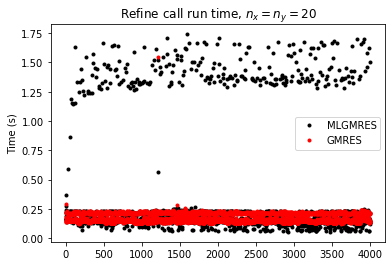

In [10]:
pp.plot(run_timeP2_ML_list,'.k',label='MLGMRES')
pp.plot(GmresRunTimeOriginal2,'.r',label='GMRES')
pp.title('Refine call run time, $n_x=n_y=20$')
pp.ylabel('Time (s)')
pp.legend(loc='best')
pp.savefig('EntireTime1.png')

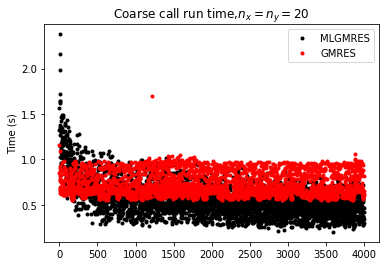

In [11]:
pp.plot(run_timeP1_ML_list,'.k',label='MLGMRES')
pp.plot(GmresRunTimeOriginal,'.r',label='GMRES')
pp.title('Coarse call run time,$n_x=n_y=20$')
pp.ylabel('Time (s)')
pp.legend(loc='best')
pp.savefig('EntireTime2.png')

/home/kl748/Research/NERSC/GMRES-Learning/src_dir/util.py:68: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(a[-Window-1:-1])/Window


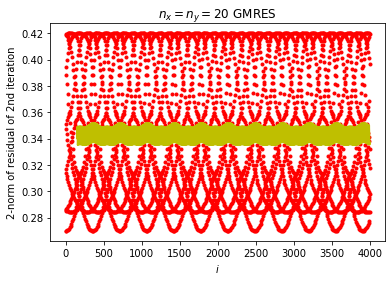

In [12]:
AVG=np.zeros((n_steps,1))
Err_Array=np.asarray(NonML_Err_List)
count=np.arange(0,n_steps)

for j in range(0,n_steps):
    AVG[j]=moving_average(np.asarray(Err_Array[:j]),j)

    
    
pp.plot(count,np.asarray(NonML_Err_List),'.r',count[150:-1],AVG[150:-1],'y')
pp.xlabel('$i$')
pp.ylabel('2-norm of residual of 2nd iteration')
pp.title('$n_x=n_y=20$ GMRES')
pp.savefig('GMRES.png')

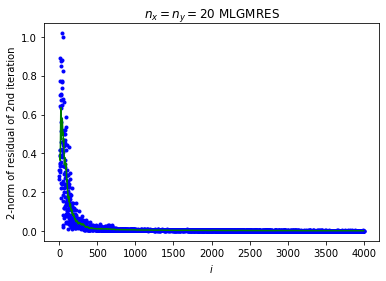

In [13]:
Err_Array_ML=np.asarray(Err_list)
AVGML=np.zeros((n_steps,1))

for j in range(0,n_steps):
    AVGML[j]=moving_average(np.asarray(Err_Array_ML[:j]),j)

pp.plot(count,np.asarray(Err_Array_ML),'.b',count[10:-1],AVGML[10:-1],'g')
pp.xlabel('$i$')
pp.ylabel('2-norm of residual of 2nd iteration')
pp.title('$n_x=n_y=20$ MLGMRES')
pp.savefig('MLGMRES.png')

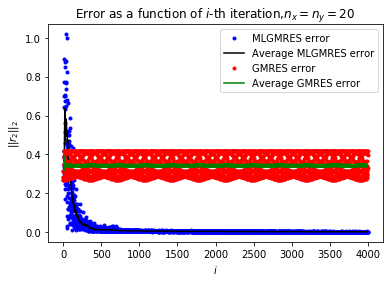

In [14]:
pp.plot(count,Err_Array_ML,'.b',label='MLGMRES error')
pp.plot(count[10:-1],AVGML[10:-1],'k',label='Average MLGMRES error')
pp.plot(count,Err_Array,'.r',label='GMRES error')
pp.plot(count[10:-1],AVG[10:-1],'g',label='Average GMRES error')

pp.xlabel('$i$')
pp.ylabel('$||r_2||_2$')
pp.title('Error as a function of $i$-th iteration,$n_x=n_y=20$ ')
pp.legend(loc='best')
pp.savefig('Compare.png')

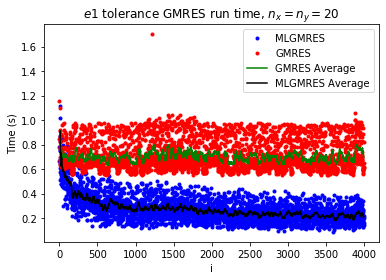

In [15]:
GmresRunTimeOriginal_AVG=np.zeros((n_steps,1))
ML_GMRES_Time_AVG=np.zeros((n_steps,1))


for j in range(0,n_steps):
    GmresRunTimeOriginal_AVG[j]=moving_average(np.asarray(GmresRunTimeOriginal[:j]),j)

for j in range(0,n_steps):
    ML_GMRES_Time_AVG[j]=moving_average(np.asarray(ML_GMRES_Time_list[:j]),j)
    
    
pp.plot(ML_GMRES_Time_list,'.b',label='MLGMRES')
pp.plot(GmresRunTimeOriginal,'.r', label='GMRES')
pp.plot(count[10:-1],GmresRunTimeOriginal_AVG[10:-1],'g', label='GMRES Average')
pp.plot(count[10:-1],ML_GMRES_Time_AVG[10:-1],'k', label='MLGMRES Average')

pp.ylabel('Time (s)')
pp.xlabel('i')
pp.title('$e1$ tolerance GMRES run time, $n_x=n_y=20$')
pp.legend(loc='best')
pp.savefig('Runtime1.png')

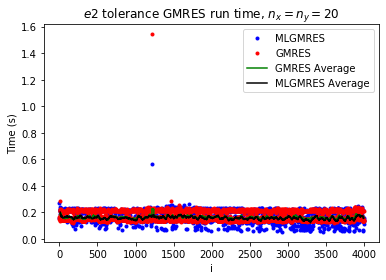

In [16]:
GmresRunTimeOriginal2_AVG=np.zeros((n_steps,1))
ML_GMRES_Time2_AVG=np.zeros((n_steps,1))
count=np.arange(0,n_steps)


for j in range(0,n_steps):
    GmresRunTimeOriginal2_AVG[j]=moving_average(np.asarray(GmresRunTimeOriginal2[:j]),j)

for j in range(0,n_steps):
    ML_GMRES_Time2_AVG[j]=moving_average(np.asarray(ML_GMRES_Time_list2[:j]),j)
    
    
pp.plot(ML_GMRES_Time_list2,'.b',label='MLGMRES')
pp.plot(GmresRunTimeOriginal2,'.r', label='GMRES')
pp.plot(count[10:-1],GmresRunTimeOriginal2_AVG[10:-1],'g', label='GMRES Average')
pp.plot(count[10:-1],ML_GMRES_Time2_AVG[10:-1],'k', label='MLGMRES Average')

pp.ylabel('Time (s)')
pp.xlabel('i')
pp.title('$e2$ tolerance GMRES run time, $n_x=n_y=20$')
pp.legend(loc='best')
pp.savefig('Runtime2.png')

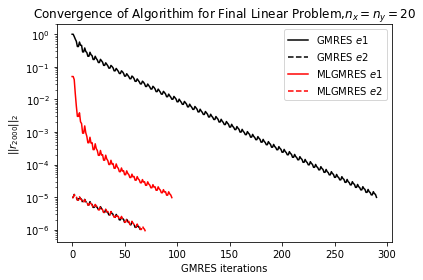

In [17]:
ML_Err=resid(A, Out, b/b_norm)
ML_Err2=resid(A, Out2, b/b_norm)



NonML_Err=resid(A, NonML_Out1, b/b_norm)
NonML_Err2=resid(A, NonML_Out2, b/b_norm)

pp.semilogy(NonML_Err,'k',label='GMRES $e1$')
pp.semilogy(NonML_Err2,'--k',label='GMRES $e2$')
pp.semilogy(ML_Err,'r',label='MLGMRES $e1$')
pp.semilogy(ML_Err2,'--r',label='MLGMRES $e2$')
pp.legend(loc='best')
pp.xlabel('GMRES iterations')
pp.ylabel('$||r_{2000}||_2$')
pp.title('Convergence of Algorithim for Final Linear Problem,$n_x=n_y=20$')
pp.savefig('Error.png')